## Primary Analysis Notebook for Client Default Prediction

### Overview

This notebook serves as the central piece of analysis in this project to predict client defaults. It primarily utilizes data from `applications_train.csv`, focusing on thorough exploration, feature selection, and model development. Key steps outlined in my plan document are followed, and certain aspects are delegated to supplementary notebooks to maintain clarity and focus in this main notebook.

### Structure and Contents

- **Dataset Characteristics**: Initial exploration of the dataset, understanding its structure and characteristics.
- **Target Class Frequencies and Data Types**: Analysis of class distributions and data type categorizations.
- **Correlation and Statistical Analysis**: In-depth examination of feature correlations and statistical significance in relation to the target variable.
- **Feature Selection and Engineering**: Detailed process of handling missing values, addressing high cardinality, and optimizing feature selection. External notebooks cover advanced feature selection techniques like RFECV, BORUTA, and SHAP analysis.
- **Benchmark Models**: Initial model evaluations using `LazyClassifier` with and without SMOTE, providing baseline performances.
- **Model Development**: Building and tuning models using XGBoost and CatBoost. This includes:
    - **SMOTE Application**: Addressing class imbalance.
    - **XGBoost Modeling**: Developing models based on performance metrics, with custom scorer focusing on F2 score and ROC AUC.
    - **Hyperparameter Tuning**: Extensive tuning using RandomizedSearchCV, as detailed in external notebooks.
    - **CatBoost Modeling**: Various CatBoost models, examining different configurations.
- **Feature Filtering**: Utilizing SHAP values from both XGBoost and CatBoost models to refine the feature set.
- **SHAP Analysis and Comparison**: Comparative analysis of SHAP values from both models, emphasizing the differences in feature importance.

### Methodological Highlights

- **Hyperparameter Tuning**: Advanced techniques like RandomizedSearchCV are employed in other notebooks, ensuring optimal model performance.
- **Feature Selection with SHAP and BORUTA**: These methodologies are explored in external notebooks, highlighting my approach to identifying impactful features.
- **External Notebooks for Specific Tasks**: Complex tasks like RFECV and advanced feature selection processes are documented in separate notebooks to reduce clutter and enhance readability.


In [86]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from boruta import BorutaPy
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, recall_score,
    roc_auc_score, make_scorer
)
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import roc_curve, auc
from scipy.stats import pointbiserialr, chi2_contingency, mannwhitneyu
from autofeat import AutoFeatClassifier, AutoFeatRegressor
from lazypredict.Supervised import LazyClassifier
import shap
import scipy.stats as stats
import missingno as msno
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/home/user/Downloads/Capstone project/home-credit-default-risk/application_train.csv')

### Dataset Characteristics

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


---
- `307,511 entries` and `121` initial features (without the target feature)
---

In [4]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,Revolving loans,M,Y,Y,0,67500.00,135000.00,6750.00,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
3,100006,0,Cash loans,F,N,Y,0,135000.00,312682.50,29686.50,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.00,513000.00,21865.50,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


### Target class frequencies

In [6]:
class_0_percentage = (data["TARGET"].value_counts()
                      [0] / len(data)*100).round(2)
class_1_percentage = (data["TARGET"].value_counts()
                      [1] / len(data)*100).round(2)
len(data), data["TARGET"].value_counts()[0], data["TARGET"].value_counts()[1]
print(
    f'Class 0 (not default) frequency: {class_0_percentage}, Class 1 (default) frequency {class_1_percentage}')

Class 0 (not default) frequency: 91.93, Class 1 (default) frequency 8.07


---
- `91.93 %` of values are class `0`,only `8.07 %` are class `1`. Arround 11x difference. 
- Meaning, our classification task is mroe difficult due to this inherent imbalance in target classes. 
- The appropriate metrics in model evaluation should be chosen to reflect this. 
- Choosing the evaluation metrics and thresholds that will define satisfactory performance, will depend on costs and benefits related to false positives, and false negatives in both classes. 
- The modeling could be done differently for target segment of customers in which these costs/benefits have higher leverage onm the bank. 
- This could be developed further as the product progresses. 
- Depending on extent the banks are comfortable to be exposed and to risk. 
- Usinf F2 score as primary metric will be my decvisions, as it puts more focus on recall than precision, while still keeping more balabnced prediction, than using raw Recall. Besides F2, I will also bve using F1 score and AUC. 
---

### Data types

In [7]:
data.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

#### Feature data types analysis, re-classification, mapping and more. 

In [8]:
data.drop('SK_ID_CURR', axis=1, inplace=True)

In [9]:
data['EMERGENCYSTATE_MODE'].value_counts()

EMERGENCYSTATE_MODE
No     159428
Yes      2328
Name: count, dtype: int64

In [10]:
data = data[data['CODE_GENDER'] != 'XNA']

data['CODE_GENDER'] = data['CODE_GENDER'].map({'F': 1, 'M': 0})

data['FLAG_OWN_CAR'] = data['FLAG_OWN_CAR'].map({'N': 0, 'Y': 1})

data['FLAG_OWN_REALTY'] = data['FLAG_OWN_REALTY'].map({'N': 0, 'Y': 1})

data['EMERGENCYSTATE_MODE'] = data['EMERGENCYSTATE_MODE'].map(
    {'No': 0, 'Yes': 1})


education_mapping = {
    'Academic degree': 5,
    'Higher education': 4,
    'Incomplete higher': 3,
    'Secondary / secondary special': 2,
    'Lower secondary': 1
}

data['NAME_EDUCATION_TYPE'] = data['NAME_EDUCATION_TYPE'].map(
    education_mapping)

data = data * 1

In [11]:
binary_features = [col for col in data.columns if data[col].nunique() == 2]
non_binary_numeric_data = data.select_dtypes(include=['int64', 'float64'])
sub_20_features = non_binary_numeric_data.columns[non_binary_numeric_data.nunique(
) <= 20]  # Numeric with less than 20 unique categories

categorical_converted = ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']
categorical_object_features = data.select_dtypes(include=['object'])

In [12]:
all_categorical_features = binary_features + \
    list(categorical_object_features.columns) + categorical_converted
all_categorical_features = list(set(all_categorical_features))

In [13]:
numeric_data = data.drop(all_categorical_features, axis=1)

In [14]:
data['is_cash_loan'] = data['NAME_CONTRACT_TYPE'].map(
    {'Cash loans': 1, 'Revolving loans': 0})

In [15]:
all_categorical_features.append('is_cash_loan')
categorical_data = data[all_categorical_features]

In [16]:
data.drop('NAME_CONTRACT_TYPE', axis=1, inplace=True)
categorical_data.drop('NAME_CONTRACT_TYPE', axis=1, inplace=True)

In [17]:
numeric_data.shape

(307507, 71)

In [18]:
categorical_data.shape

(307507, 50)

In [19]:
data.shape

(307507, 121)

---
- We end up with same number of features, no wrong outputs here.
- 4 entries removed during this process. 
---

### Missing values

In [20]:
missing_values_count = data.isnull().sum()
missing_percentage = (missing_values_count / len(data)) * 100

missing_values_df = pd.DataFrame({
    'Number of Missing Values': missing_values_count,
    'Percentage (%)': missing_percentage
})

missing_values_df = missing_values_df[missing_values_df['Number of Missing Values'] > 0] \
    .sort_values(by='Percentage (%)', ascending=False)

missing_values_df.describe()

,Number of Missing Values,Percentage (%)
count,67.00,67.00
mean,136602.79,44.42
std,74085.38,24.09
min,1.00,0.00
25%,78677.00,25.59
50%,156060.00,50.75
75%,192757.50,62.68
max,214862.00,69.87


---
- 67 out of 121 columns with missing values.
- Mean missing vlaues: 136,604 - 44.42%. 
- Standard deviation of approximately 74,086, high variability. 
- The percentage of missing data ranges from nearly 0% to about 69.87% across different columns.
- Missing vlues will be handled during feature selection process later in the notebook. 
---

### Correlation analysis

#### Numeric features correlation with statistical significance

---
- First only numeric_features correlation, using Spearman's Rank correlation, due to wide variety of numeric features included. 
---

In [22]:
correlation_results_numeric = pd.DataFrame(
    columns=['Feature1', 'Feature2', 'Correlation', 'P-value'])

for i in range(len(numeric_data.columns)):
    for j in range(i+1, len(numeric_data.columns)):
        feature1 = numeric_data.columns[i]
        feature2 = numeric_data.columns[j]
        corr, p_value = stats.spearmanr(
            numeric_data[feature1], numeric_data[feature2])

        if p_value < 0.05:
            correlation_results_numeric = pd.concat([correlation_results_numeric, pd.DataFrame({
                'Feature1': [feature1],
                'Feature2': [feature2],
                'Correlation': [corr],
                'P-value': [p_value]
            })], ignore_index=True)

In [23]:
correlation_results_numeric.sort_values(
    by='Correlation', ascending=False).head(10)

,Feature1,Feature2,Correlation,P-value
7,AMT_INCOME_TOTAL,AMT_CREDIT,0.41,0.00
3,CNT_CHILDREN,DAYS_BIRTH,0.37,0.00
33,DAYS_BIRTH,DAYS_REGISTRATION,0.30,0.00
34,DAYS_BIRTH,DAYS_ID_PUBLISH,0.26,0.00
8,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,0.24,0.00
5,CNT_CHILDREN,DAYS_REGISTRATION,0.18,0.00
23,NAME_EDUCATION_TYPE,DAYS_BIRTH,0.16,0.00
31,REGION_POPULATION_RELATIVE,HOUR_APPR_PROCESS_START,0.13,0.00
15,AMT_CREDIT,NAME_EDUCATION_TYPE,0.10,0.00
14,AMT_INCOME_TOTAL,HOUR_APPR_PROCESS_START,0.10,0.00


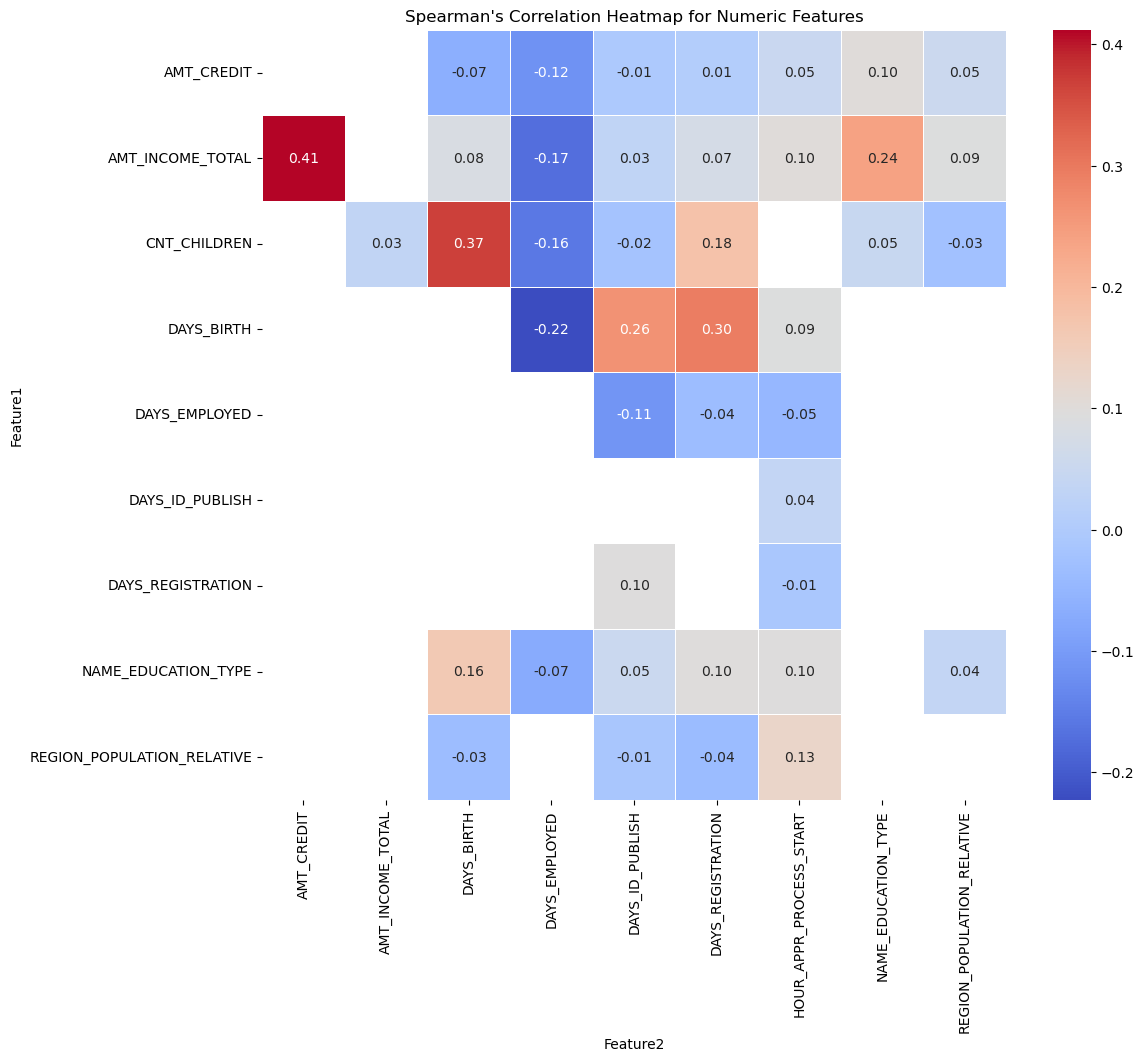

In [24]:
correlation_matrix = correlation_results_numeric.pivot(
    index='Feature1', columns='Feature2', values='Correlation')
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True,
            cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Spearman's Correlation Heatmap for Numeric Features")
plt.show()

In [25]:
correlation_results_numeric['Correlation'].describe()

count   42.00
mean     0.05
std      0.13
min     -0.22
25%     -0.03
50%      0.04
75%      0.10
max      0.41
Name: Correlation, dtype: float64

---
- We can see relatively low correlation among the p-value significant correlations.
- Range from -0.22 to 0.41
- Mean of 0.04
- This is a positive result in a way, showing that the features are not correlated, more positive prospects for the modeling phase. 
---

In [26]:
correlation_results_numeric.sort_values(
    by='Correlation', ascending=False).head(3)

,Feature1,Feature2,Correlation,P-value
7,AMT_INCOME_TOTAL,AMT_CREDIT,0.41,0.00
3,CNT_CHILDREN,DAYS_BIRTH,0.37,0.00
33,DAYS_BIRTH,DAYS_REGISTRATION,0.30,0.00


---
- These are top 3 correlated features from this subset.
- We see income and credit being correlated positively, which is sensible.
---

In [27]:
correlation_results_numeric.sort_values(
    by='Correlation', ascending=False).tail(3)

,Feature1,Feature2,Correlation,P-value
4,CNT_CHILDREN,DAYS_EMPLOYED,-0.16,0.00
11,AMT_INCOME_TOTAL,DAYS_EMPLOYED,-0.17,0.00
32,DAYS_BIRTH,DAYS_EMPLOYED,-0.22,0.00


---
- Note: DAYS_EMPLOYED is in negative format increasing towards zero of the data collection moment. 
- The most negatively correlated features. 
- All sensible correlations with days employed, more days employed, more childeren, more income, more old they are. 
---

In [28]:
binary_features = [
    col for col in categorical_data.columns if categorical_data[col].nunique() == 2]
binary_data = data[binary_features]

#### Binary and Continuous data correlation with statistical significance

In [29]:
correlation_list = []

for binary_feature in binary_data.columns:
    for numeric_feature in numeric_data.columns:
        binary_series = pd.to_numeric(
            binary_data[binary_feature], errors='coerce')
        temp_df = pd.DataFrame({
            'binary': binary_series,
            'numeric': numeric_data[numeric_feature]
        })

        temp_df = temp_df.dropna()

        if not temp_df.empty:
            corr, p_value = pointbiserialr(
                temp_df['binary'], temp_df['numeric'])

            if p_value < 0.05:
                correlation_list.append({
                    'Binary_Feature': binary_feature,
                    'Numeric_Feature': numeric_feature,
                    'Correlation': corr,
                    'P-value': p_value
                })

correlation_results = pd.DataFrame(correlation_list)

In [30]:
correlation_results.sort_values(by='Correlation', ascending=False).head(10)

,Binary_Feature,Numeric_Feature,Correlation,P-value
113,FLAG_EMP_PHONE,DAYS_BIRTH,0.62,0.00
308,FLAG_DOCUMENT_6,DAYS_EMPLOYED,0.60,0.00
1262,CODE_GENDER,EXT_SOURCE_1,0.31,0.00
116,FLAG_EMP_PHONE,DAYS_ID_PUBLISH,0.27,0.00
1011,REG_CITY_NOT_WORK_CITY,DAYS_BIRTH,0.24,0.00
1578,is_cash_loan,AMT_ANNUITY,0.24,0.00
106,FLAG_EMP_PHONE,CNT_CHILDREN,0.24,0.00
118,FLAG_EMP_PHONE,CNT_FAM_MEMBERS,0.23,0.00
1577,is_cash_loan,AMT_CREDIT,0.22,0.00
115,FLAG_EMP_PHONE,DAYS_REGISTRATION,0.21,0.00


---
- Top 10 most positively correlated p-value significant features (dataframe above)

---

In [31]:
correlation_results.sort_values(by='Correlation', ascending=False).tail(10)

,Binary_Feature,Numeric_Feature,Correlation,P-value
310,FLAG_DOCUMENT_6,DAYS_ID_PUBLISH,-0.18,0.00
640,TARGET,EXT_SOURCE_3,-0.18,0.00
1018,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,-0.19,0.00
1093,LIVE_CITY_NOT_WORK_CITY,DAYS_EMPLOYED,-0.22,0.00
385,FLAG_WORK_PHONE,DAYS_EMPLOYED,-0.23,0.00
527,FLAG_DOCUMENT_3,DAYS_EMPLOYED,-0.25,0.00
1012,REG_CITY_NOT_WORK_CITY,DAYS_EMPLOYED,-0.25,0.00
120,FLAG_EMP_PHONE,EXT_SOURCE_1,-0.29,0.00
307,FLAG_DOCUMENT_6,DAYS_BIRTH,-0.41,0.00
114,FLAG_EMP_PHONE,DAYS_EMPLOYED,-1.00,0.00


---


- Top 10 most negatively correlated p-value significant features (dataframe above)

---

In [32]:
correlation_results['Correlation'].describe()

count   1629.00
mean       0.00
std        0.06
min       -1.00
25%       -0.02
50%        0.01
75%        0.02
max        0.62
Name: Correlation, dtype: float64

---
- Overall not high correlation ebtween features.
- There are few outliers but nothing too significant other than that. 
- Mean of 0.001454, and IQR -0.016 - 0.019 also suggest low correlation for most features. 
- Almost perfect correlation on the negative side between FLAG_EMP_PHONE and DAYS_EMPLOYED features. Next closes one arround -0.4. 
---

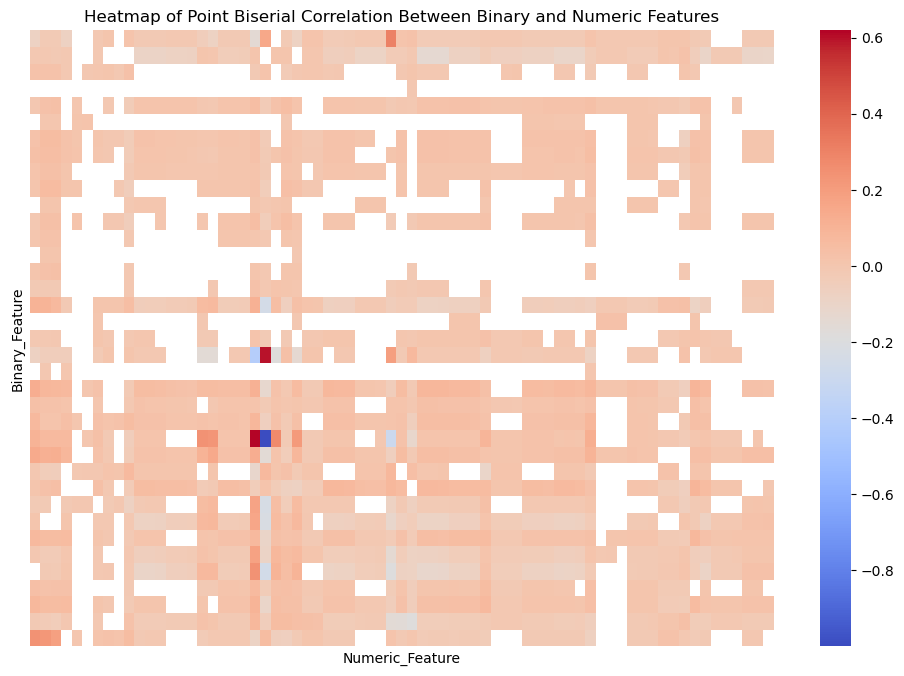

In [33]:
correlation_matrix = correlation_results.pivot(
    index='Binary_Feature', columns='Numeric_Feature', values='Correlation')
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f",
            xticklabels=False, yticklabels=False)
plt.title('Heatmap of Point Biserial Correlation Between Binary and Numeric Features')
plt.show()

- The described situation visualized, we see mostly arround 0 correlation.

### Target class proportions within some categorical features

In [34]:
def mean_target_per_category_percentage(feature_name):
    return (data.groupby(feature_name)['TARGET'].mean() * 100).sort_values(ascending=False)

interesting_features = [
    'is_cash_loan',
    'CODE_GENDER',
    'NAME_EDUCATION_TYPE',
    'NAME_INCOME_TYPE',
    'FLAG_OWN_REALTY',
    'OCCUPATION_TYPE',
    'NAME_FAMILY_STATUS'
]

for feature in interesting_features:
    mean_target_percentage = mean_target_per_category_percentage(feature)
    print(
        f"Mean TARGET per category (in %) for {feature}:\n{mean_target_percentage}\n")

Mean TARGET per category (in %) for is_cash_loan:
is_cash_loan
1   8.35
0   5.48
Name: TARGET, dtype: float64

Mean TARGET per category (in %) for CODE_GENDER:
CODE_GENDER
0   10.14
1    7.00
Name: TARGET, dtype: float64

Mean TARGET per category (in %) for NAME_EDUCATION_TYPE:
NAME_EDUCATION_TYPE
1   10.93
2    8.94
3    8.49
4    5.36
5    1.83
Name: TARGET, dtype: float64

Mean TARGET per category (in %) for NAME_INCOME_TYPE:
NAME_INCOME_TYPE
Maternity leave        40.00
Unemployed             36.36
Working                 9.59
Commercial associate    7.48
State servant           5.75
Pensioner               5.39
Businessman             0.00
Student                 0.00
Name: TARGET, dtype: float64

Mean TARGET per category (in %) for FLAG_OWN_REALTY:
FLAG_OWN_REALTY
0   8.32
1   7.96
Name: TARGET, dtype: float64

Mean TARGET per category (in %) for OCCUPATION_TYPE:
OCCUPATION_TYPE
Low-skill Laborers      17.16
Drivers                 11.33
Waiters/barmen staff    11.28
Security sta

#### Descriptive analysis of these proportions

---
- `NAME_CONTRACT_TYPE:`

Cash loans have a default rate of 8.35%, higher than revolving loans.
Revolving loans show a default rate of 5.48%.

- `CODE_GENDER:`

The default rate for males is observed at 10.14%.
Females have a default rate of 7.00%.

- `NAME_EDUCATION_TYPE:`

Individuals with lower secondary education show the highest default rate at 10.93%. Those with secondary or secondary special education have default rates of 8.94%, while those with incomplete higher education show 8.48%. Higher education and academic degree holders have lower default rates of 5.36% and 1.83%, respectively.

- `NAME_INCOME_TYPE:`

The default rate for individuals on maternity leave is 40.00%, and for unemployed individuals, it is 36.36%.
Working individuals and commercial associates show default rates of 9.59% and 7.48%, respectively.
State servants and pensioners have lower default rates of 5.75% and 5.39%, respectively.
Businessmen and students are observed with a default rate of 0.00%.

- `FLAG_OWN_REALTY:`

Individuals not owning real estate have a default rate of 8.32%.
Those owning real estate show a slightly lower default rate of 7.96%.

- `OCCUPATION_TYPE:`

The highest default rate is observed among low-skill laborers at 17.15%.
Other occupations such as drivers, waiters/barmen staff, and security staff have default rates ranging from 10.74% to 11.33%.
Professions like sales staff, cleaning staff, and cooking staff show moderate default rates around 9% to 10%.
Occupations like realty agents, secretaries, and medicine staff have lower default rates, ranging from 6.70% to 7.86%.
The lowest default rate of 4.83% is observed among accountants.

- `NAME_FAMILY_STATUS:`

Individuals in civil marriages and those single/not married have higher default rates of 9.94% and 9.81%, respectively.
Separated individuals show a default rate of 8.19%.
Married individuals have a default rate of 7.56%, while widows show the lowest rate at 5.82%.

---

### Statistical tests on binary categorical features and default rates


- Chi-Squared tests for three categorical features: 'FLAG_OWN_REALTY', 'is_cash_loan', and 'CODE_GENDER'. Null hypothesis (H0) for each of these features is that the proportions of the feature categories are equal with respect to our 'TARGET' variable. 

In [35]:
features_for_test = ['FLAG_OWN_REALTY', 'is_cash_loan', 'CODE_GENDER']


def perform_chi_squared_test(feature):
    contingency_table = pd.crosstab(data[feature], data['TARGET'])

    chi2, p_value, _, _ = chi2_contingency(contingency_table)

    print(f"Chi-squared test for {feature}:")
    print(f"Chi-squared statistic: {chi2:.2f}")
    print(f"P-value: {p_value:.4f}\n")
    print(f"Contingency table for {feature}:\n{contingency_table}\n")

    if p_value < 0.05:
        print(
            f"The difference in default rates for {feature} is statistically significant.\n")
    else:
        print(
            f"There is no significant difference in default rates for {feature}.\n")


for feature in features_for_test:
    perform_chi_squared_test(feature)

Chi-squared test for FLAG_OWN_REALTY:
Chi-squared statistic: 11.57
P-value: 0.0007

Contingency table for FLAG_OWN_REALTY:
TARGET                0      1
FLAG_OWN_REALTY               
0                 86357   7842
1                196325  16983

The difference in default rates for FLAG_OWN_REALTY is statistically significant.

Chi-squared test for is_cash_loan:
Chi-squared statistic: 292.96
P-value: 0.0000

Contingency table for is_cash_loan:
TARGET             0      1
is_cash_loan               
0              27671   1604
1             255011  23221

The difference in default rates for is_cash_loan is statistically significant.

Chi-squared test for CODE_GENDER:
Chi-squared statistic: 920.01
P-value: 0.0000

Contingency table for CODE_GENDER:
TARGET            0      1
CODE_GENDER               
0             94404  10655
1            188278  14170

The difference in default rates for CODE_GENDER is statistically significant.



#### The description

---

- FLAG_OWN_REALTY:
    Statistic: `11.57`
    P-value: `0.0007`
    The low p-value suggests that there is a statistically significant difference in the default rates between the groups within the 'FLAG_OWN_REALTY' category. In other words, the ownership of realty appears to have a significant association with the target variable.
    Contingency Table: Indicates that 7842 out of 86357 individuals who do not own realty (about 9.08%) and 16983 out of 196325 who do own realty (about 8.65%) are in the '1' category of the 'TARGET'.
 
- is_cash_loan: 
    Statistic: `292.96`
    P-value: `0.0000`
    The result is highly statistically significant, implying a strong association between the type of loan ('is_cash_loan') and the target variable. `The null hypothesis of equal proportions is rejected`.
    Contingency Table: Shows that 1604 out of 27671 non-cash (revolving) loans (about 5.80%) and 23221 out of 255011 cash loans (about 9.11%) fall into the '1' category of the 'TARGET'.
    
    
- CODE_GENDER:
    Statistic: `920.01`
    P-value: `0.0000`
    This indicates a very strong association between gender and the target variable, with a statistically significant difference in default rates between genders.
    Contingency Table: Shows that 10655 out of 94404 in gender category '0' (MALE) about 11.29%, and 14170 out of 188278 in gender category '1' (FEMALE) about 7.52%, fall into the '1' category of the 'TARGET'.
    
    
- For all three features, the very low p-values indicate that the differences in default rates across the categories of each feature are statistically significant. It's important to note that while these tests show associations, they do not imply causation.

----

### 95% Confidence Intervals for mean income of defaulting and non-defaulting instances

In [36]:
grouped_data = data.groupby('TARGET')['AMT_INCOME_TOTAL']
confidence_level = 0.95
for group in grouped_data.groups:
    group_data = grouped_data.get_group(group)
    degrees_freedom = len(group_data) - 1
    mean = np.mean(group_data)
    standard_error = stats.sem(group_data)

    confidence_interval = stats.t.interval(
        confidence_level, degrees_freedom, mean, standard_error)

    print(f"TARGET = {group}")
    print(f"Mean Income: {mean}")
    print(f"95% Confidence Interval: {confidence_interval}\n")

TARGET = 0
Mean Income: 169077.47219998087
95% Confidence Interval: (168670.21161248983, 169484.7327874719)

TARGET = 1
Mean Income: 165611.76090634443
95% Confidence Interval: (156323.00846400924, 174900.5133486796)



---
Target = 0:
- `Mean Income:` Approximately 169,077.47, 
- `95% Confidence Interval:` (168,670.21, 169,484.73)
- I am 95% confident that the true average income for the TARGET=0 group lies between approximately 168,670.21 and 169,484.73.

---
TARGET = 1:

- `Mean Income:` Approximately 165,611.76
- `95% Confidence Interval:` (156,323.01, 174,900.51)
- I am 95% confident that the true average income for the TARGET=1 group lies between approximately 156,323.01 and 174,900.51.


- The confidence interval for TARGET=1 is wider than for TARGET=0, `indicating more variability or uncertainty in the average income estimate for the TARGET=1 group`.
---

### Confidence Intervals and Mann-Whitney U Test for AMT_INCOME_TOTAL feature

In [37]:
group0 = data[data['TARGET'] == 0]['AMT_INCOME_TOTAL']
group1 = data[data['TARGET'] == 1]['AMT_INCOME_TOTAL']

In [38]:
group0.describe()

count     282682.00
mean      169077.47
std       110476.91
min        25650.00
25%       112500.00
50%       148500.00
75%       202500.00
max     18000090.00
Name: AMT_INCOME_TOTAL, dtype: float64

In [39]:
group1.describe()

count       24825.00
mean       165611.76
std        746676.96
min         25650.00
25%        112500.00
50%        135000.00
75%        202500.00
max     117000000.00
Name: AMT_INCOME_TOTAL, dtype: float64

---
Given the non-normal distribution of data, indicated by the large standard deviations and the substantial difference between the mean and median values, a non-parametric test would be more appropriate. Non-parametric tests don't assume an underlying normal distribution and are better suited for skewed data or data with outliers.

---

In [40]:
u_statistic, p_value = mannwhitneyu(group0, group1)

print(f"U-Statistic: {u_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("We reject the null hypothesis. There is a significant difference in income distributions between the two TARGET groups.")
else:
    print("We fail to reject the null hypothesis. There is no significant difference in income distributions between the two TARGET groups.")

U-Statistic: 3643081669.5
P-value: 1.037423288995223e-23
We reject the null hypothesis. There is a significant difference in income distributions between the two TARGET groups.


----

## Feature selection process

---
- Feature selection process using BORUTA and RFECV can be found in `feature_selection_notebook.ipynb`
- I will import the results from it into this notebook. Detailed explanation of what was done can be found in mentioned notebook. 

---

In [41]:
data_features_selection = data.copy()

#### Handling Missing values

In [42]:
imputer = SimpleImputer(strategy='median')
data_features_selection[numeric_data.columns.values] = imputer.fit_transform(
    data_features_selection[numeric_data.columns.values])

missing_to_impute = data_features_selection.isnull().sum(
)[data_features_selection.isnull().sum() != 0].index


def proportional_imputation(series):
    distribution = series.dropna().value_counts(normalize=True)
    missing = series.isnull().sum()
    imputed_values = np.random.choice(
        distribution.index, size=missing, p=distribution.values)
    series[series.isnull()] = imputed_values
    return series


data_features_selection['NAME_TYPE_SUITE'] = proportional_imputation(
    data_features_selection['NAME_TYPE_SUITE'])
data_features_selection['OCCUPATION_TYPE'] = proportional_imputation(
    data_features_selection['OCCUPATION_TYPE'])
data_features_selection['FONDKAPREMONT_MODE'] = proportional_imputation(
    data_features_selection['FONDKAPREMONT_MODE'])
data_features_selection['HOUSETYPE_MODE'] = proportional_imputation(
    data_features_selection['HOUSETYPE_MODE'])
data_features_selection['WALLSMATERIAL_MODE'] = proportional_imputation(
    data_features_selection['WALLSMATERIAL_MODE'])
data_features_selection['EMERGENCYSTATE_MODE'] = proportional_imputation(
    data_features_selection['EMERGENCYSTATE_MODE'])

---
- All of the missing values are handled
- I opted out for simple median imputer and proportional imputer approach for missing values. 
- This approach I used is probably not the most precise one, but I will proceed with it due to simplicity. 
- More complex approach would be to check the individual feature distributions, and frequencies of categories within. Read a bit more into what categories mean. For rare even categories maybe approach differently. 

---

#### Solving high cardinality in some features 

---
- As the object type featrues left had high cardinality, they were not appropriate for one hot encoding.
- My idea was to recategorize them into less but still equally meaningfull categories, instead of categorizing them into 'Other'

---

In [43]:
def categorize_occupation(occupation):
    if occupation in ['Managers', 'Accountants', 'High skill tech staff', 'IT staff']:
        return 'White-Collar'
    elif occupation in ['Medicine staff', 'HR staff']:
        return 'Healthcare and Public Service'
    elif occupation in ['Drivers', 'Security staff', 'Cooking staff', 'Private service staff', 'Realty agents']:
        return 'Skilled Manual Labor'
    elif occupation in ['Laborers', 'Sales staff', 'Core staff', 'Cleaning staff', 'Low-skill Laborers', 'Waiters/barmen staff', 'Secretaries']:
        return 'General Labor and Services'
    else:
        return occupation


def categorize_organization_type(org_type):
    if 'Business Entity' in org_type or 'Trade:' in org_type or 'Industry:' in org_type or org_type in ['Bank', 'Insurance', 'Realtor']:
        return 'Corporate and Business Entities'
    elif org_type in ['Government', 'School', 'Medicine', 'University', 'Kindergarten', 'Military', 'Police', 'Security Ministries', 'Electricity', 'Emergency', 'Housing']:
        return 'Public and Social Services'
    elif org_type == 'Self-employed':
        return 'Self-Employed and Freelance'
    elif 'Transport:' in org_type or org_type in ['Telecom', 'Postal']:
        return 'Transport and Communications'
    elif org_type == 'Agriculture':
        return 'Agriculture and Environment'
    elif org_type in ['Culture', 'Religion']:
        return 'Cultural, Recreational, and Religious Organizations'
    else:
        return 'Other'


data_features_selection['NAME_TYPE_SUITE'] = data_features_selection['NAME_TYPE_SUITE'].replace(
    ['Other_B', 'Other_A', 'Group of people'], 'Other')
data_features_selection['NAME_INCOME_TYPE'] = data_features_selection['NAME_INCOME_TYPE'].replace(
    ['Unemployed', 'Student', 'Businessman', 'Maternity leave'], 'Other')
data_features_selection['OCCUPATION_TYPE'] = data_features_selection['OCCUPATION_TYPE'].apply(
    categorize_occupation)
data_features_selection['ORGANIZATION_TYPE'] = data_features_selection['ORGANIZATION_TYPE'].apply(
    categorize_organization_type)

In [44]:
object_cols = data_features_selection.select_dtypes(include=['object']).columns
encoded_data = pd.get_dummies(
    data_features_selection[object_cols], drop_first=True)
data_features_selection = data_features_selection.drop(object_cols, axis=1)
data_features_selection = pd.concat(
    [data_features_selection, encoded_data], axis=1)

for col in data_features_selection.select_dtypes(include=['bool']).columns:
    data_features_selection[col] = data_features_selection[col] * 1

In [45]:
data_features_selection.dtypes.value_counts()

int64      83
float64    72
Name: count, dtype: int64

In [46]:
# Converting some float features to int features
for column in data_features_selection.columns:
    if (data_features_selection[column] % 1 == 0).all():
        data_features_selection[column] = data_features_selection[column].astype(
            int)

In [47]:
data_features_selection.dtypes.value_counts()

int64      103
float64     52
Name: count, dtype: int64

#### Loading the data from feature selection process

In [48]:
filtered_data_after_boruta = pd.read_csv('filtered_data_after_boruta.csv')

In [49]:
feature_list_rfecv_2 = pd.read_csv('features_list_RFECV_2.csv')

In [50]:
filtered_data_after_boruta.head()

,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,NAME_INCOME_TYPE_Working,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Single / not married,NAME_HOUSING_TYPE_House / apartment,OCCUPATION_TYPE_White-Collar,ORGANIZATION_TYPE_Corporate and Business Entities,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Public and Social Services,ORGANIZATION_TYPE_Self-Employed and Freelance,TARGET
0,0,0,202500.00,406597.50,24700.50,351000.00,2,0.02,-9461,-637,...,1,0,1,1,0,1,0,0,0,1
1,1,0,270000.00,1293502.50,35698.50,1129500.00,4,0.00,-16765,-1188,...,0,1,0,1,0,0,0,1,0,0
2,0,1,67500.00,135000.00,6750.00,135000.00,2,0.01,-19046,-225,...,1,0,1,1,0,0,0,1,0,0
3,1,0,135000.00,312682.50,29686.50,297000.00,2,0.01,-19005,-3039,...,1,0,0,1,0,1,0,0,0,0
4,0,0,121500.00,513000.00,21865.50,513000.00,2,0.03,-19932,-3038,...,1,0,1,1,0,0,0,0,0,0


In [51]:
filtered_data_after_boruta.shape

(307507, 72)

- `71 features left` (not considering TARGET) using BORUTA method. 

In [52]:
feature_list_rfecv_2.head()

,Feature
0,AMT_INCOME_TOTAL
1,AMT_CREDIT
2,AMT_ANNUITY
3,AMT_GOODS_PRICE
4,REGION_POPULATION_RELATIVE


In [53]:
feature_list_rfecv_2.shape

(31, 1)

- `31 features` chosen with RFECV

##### Comparing features from both methods

In [54]:
rfecv_feature_list = list(feature_list_rfecv_2['Feature'])

In [55]:
boruta_features_list = list(filtered_data_after_boruta.columns.values)

In [56]:
rfecv_features_set = set(rfecv_feature_list)
boruta_features_set = set(boruta_features_list)
common_features = rfecv_features_set.intersection(boruta_features_set)
rfecv_exclusive = rfecv_features_set.difference(boruta_features_set)
boruta_exclusive = boruta_features_set.difference(rfecv_features_set)
rfecv_exclusive_set = set(rfecv_exclusive)
boruta_exclusive_set = set(boruta_exclusive)
combined_features_set = common_features.union(
    rfecv_exclusive_set, boruta_exclusive_set)
combined_features_list = list(combined_features_set)

In [57]:
print("Common Features (Selected by Both):", common_features)

Common Features (Selected by Both): {'EXT_SOURCE_1', 'DAYS_LAST_PHONE_CHANGE', 'AMT_GOODS_PRICE', 'DAYS_ID_PUBLISH', 'LANDAREA_MODE', 'DAYS_REGISTRATION', 'HOUR_APPR_PROCESS_START', 'LIVINGAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'DAYS_BIRTH', 'AMT_CREDIT', 'YEARS_BEGINEXPLUATATION_AVG', 'OWN_CAR_AGE', 'APARTMENTS_MEDI', 'BASEMENTAREA_AVG', 'LIVINGAREA_AVG', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'APARTMENTS_AVG', 'DAYS_EMPLOYED', 'LANDAREA_MEDI', 'REGION_POPULATION_RELATIVE', 'YEARS_BEGINEXPLUATATION_MODE', 'TOTALAREA_MODE', 'EXT_SOURCE_3', 'LIVINGAREA_MEDI', 'EXT_SOURCE_2'}


In [58]:
print("RFECV Exclusive Features:", rfecv_exclusive)

RFECV Exclusive Features: {'CNT_FAM_MEMBERS', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_YEAR'}


In [59]:
print("Boruta Exclusive Features:", boruta_exclusive)

Boruta Exclusive Features: {'LANDAREA_AVG', 'FLAG_EMP_PHONE', 'NONLIVINGAREA_AVG', 'FLOORSMAX_MODE', 'ENTRANCES_AVG', 'ORGANIZATION_TYPE_Other', 'ELEVATORS_MODE', 'NAME_FAMILY_STATUS_Single / not married', 'ORGANIZATION_TYPE_Public and Social Services', 'FLAG_DOCUMENT_6', 'BASEMENTAREA_MODE', 'FLAG_WORK_PHONE', 'NONLIVINGAREA_MEDI', 'FLAG_DOCUMENT_3', 'ENTRANCES_MEDI', 'FLOORSMIN_AVG', 'NAME_FAMILY_STATUS_Married', 'TARGET', 'NAME_HOUSING_TYPE_House / apartment', 'BASEMENTAREA_MEDI', 'NAME_EDUCATION_TYPE', 'FLOORSMAX_MEDI', 'FLOORSMAX_AVG', 'FLOORSMIN_MEDI', 'REGION_RATING_CLIENT', 'DEF_60_CNT_SOCIAL_CIRCLE', 'NAME_INCOME_TYPE_Working', 'REG_CITY_NOT_LIVE_CITY', 'OCCUPATION_TYPE_White-Collar', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE_Self-Employed and Freelance', 'YEARS_BUILD_MEDI', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Pensioner', 'ELEVATORS_AVG', 'FLOORSMIN_MODE', 'CODE_GENDER', 'DEF_30_CNT_SOCIAL_CIRCLE', 'i

---
- We can see interestingly RFECV chooging 4 features BORUTA didn't, as BORUTA was one with higher number of features (71), I was expecting it to include all of the features selected by RFECV.
- I will merge these 4 as well, into BORUTA 71 features, to use these as my primary modeling features going forwards.

---

In [60]:
filtered_data_final = data_features_selection[combined_features_list]

In [61]:
filtered_data_final.isnull().sum().sum()

0

In [62]:
filtered_data_final.shape

(307507, 76)

---
- Final data before modeling 76 features, 307,507 Instances

---

## Benchmark models

#### Downcasting floats and integers in memory

In [63]:
def downcast_floats(df):
    float_cols = df.select_dtypes(include=['float']).columns
    for col in float_cols:
        df[col] = pd.to_numeric(df[col], downcast='float')


def downcast_ints(df):
    int_cols = df.select_dtypes(include=['int']).columns
    for col in int_cols:
        df[col] = pd.to_numeric(df[col], downcast='integer')


downcast_floats(filtered_data_final)
downcast_ints(filtered_data_final)

filtered_data_final.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 0 to 307510
Data columns (total 76 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   LANDAREA_AVG                                       307507 non-null  float32
 1   NONLIVINGAREA_AVG                                  307507 non-null  float32
 2   ENTRANCES_AVG                                      307507 non-null  float32
 3   ORGANIZATION_TYPE_Other                            307507 non-null  int8   
 4   AMT_GOODS_PRICE                                    307507 non-null  float32
 5   NAME_FAMILY_STATUS_Single / not married            307507 non-null  int8   
 6   BASEMENTAREA_MODE                                  307507 non-null  float32
 7   LANDAREA_MODE                                      307507 non-null  float32
 8   DAYS_REGISTRATION                                  307507 non-null  float32
 9 

#### LazyClassifier sample = 30,000, without SMOTE

In [64]:
X = filtered_data_final.drop('TARGET', axis=1)
y = filtered_data_final['TARGET']

X_sample, _, y_sample, _ = train_test_split(
    X, y, train_size=30000, random_state=12, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.3, random_state=12)

clf = LazyClassifier(verbose=100, predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

  3%|██▋                                                                            | 1/29 [00:02<01:13,  2.62s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.9185555555555556, 'Balanced Accuracy': 0.5148815896960035, 'ROC AUC': 0.5148815896960035, 'F1 Score': 0.8845584307620364, 'Time taken': 2.61653995513916}


 10%|████████▏                                                                      | 3/29 [00:08<01:06,  2.57s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.9143333333333333, 'Balanced Accuracy': 0.511960987254832, 'ROC AUC': 0.511960987254832, 'F1 Score': 0.882025513389561, 'Time taken': 6.053873777389526}
{'Model': 'BernoulliNB', 'Accuracy': 0.8221111111111111, 'Balanced Accuracy': 0.581926566577046, 'ROC AUC': 0.5819265665770459, 'F1 Score': 0.8438354313181988, 'Time taken': 0.11166739463806152}


 14%|██████████▉                                                                    | 4/29 [00:17<02:06,  5.04s/it]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.9182222222222223, 'Balanced Accuracy': 0.5016258615083237, 'ROC AUC': 0.5016258615083237, 'F1 Score': 0.8801460737976173, 'Time taken': 8.82690143585205}


 28%|█████████████████████▊                                                         | 8/29 [00:18<00:32,  1.54s/it]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.8454444444444444, 'Balanced Accuracy': 0.542328907817618, 'ROC AUC': 0.542328907817618, 'F1 Score': 0.8534598751677773, 'Time taken': 0.9670095443725586}
{'Model': 'DummyClassifier', 'Accuracy': 0.9186666666666666, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8797238823256891, 'Time taken': 0.07713007926940918}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.8507777777777777, 'Balanced Accuracy': 0.5284218436476401, 'ROC AUC': 0.5284218436476401, 'F1 Score': 0.8546498791222205, 'Time taken': 0.10106396675109863}


 34%|██████████████████████████▉                                                   | 10/29 [00:21<00:26,  1.40s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.9187777777777778, 'Balanced Accuracy': 0.5006830601092896, 'ROC AUC': 0.5006830601092896, 'F1 Score': 0.8799967496558413, 'Time taken': 2.79546856880188}
{'Model': 'GaussianNB', 'Accuracy': 0.5408888888888889, 'Balanced Accuracy': 0.6038132400644001, 'ROC AUC': 0.6038132400644001, 'F1 Score': 0.6395858209584728, 'Time taken': 0.10310840606689453}


 38%|█████████████████████████████▌                                                | 11/29 [00:22<00:22,  1.25s/it]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.9127777777777778, 'Balanced Accuracy': 0.5061336616780477, 'ROC AUC': 0.5061336616780477, 'F1 Score': 0.8796964157047122, 'Time taken': 0.8477737903594971}


 41%|████████████████████████████████▎                                             | 12/29 [00:36<01:20,  4.73s/it]

{'Model': 'LabelPropagation', 'Accuracy': 0.8707777777777778, 'Balanced Accuracy': 0.5237425349163672, 'ROC AUC': 0.5237425349163672, 'F1 Score': 0.8644380576559539, 'Time taken': 13.92295503616333}


 45%|██████████████████████████████████▉                                           | 13/29 [00:55<02:18,  8.63s/it]

{'Model': 'LabelSpreading', 'Accuracy': 0.8707777777777778, 'Balanced Accuracy': 0.5237425349163672, 'ROC AUC': 0.5237425349163672, 'F1 Score': 0.8644380576559539, 'Time taken': 18.583549976348877}


 48%|█████████████████████████████████████▋                                        | 14/29 [00:55<01:33,  6.24s/it]

{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.9171111111111111, 'Balanced Accuracy': 0.507246980259662, 'ROC AUC': 0.5072469802596621, 'F1 Score': 0.8816261337830972, 'Time taken': 0.29839587211608887}


 52%|████████████████████████████████████████▎                                     | 15/29 [01:03<01:34,  6.76s/it]

{'Model': 'LinearSVC', 'Accuracy': 0.9186666666666666, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8797238823256891, 'Time taken': 8.043883562088013}


 62%|████████████████████████████████████████████████▍                             | 18/29 [01:03<00:29,  2.69s/it]

{'Model': 'LogisticRegression', 'Accuracy': 0.9177777777777778, 'Balanced Accuracy': 0.5044968950010706, 'ROC AUC': 0.5044968950010708, 'F1 Score': 0.8809648260448539, 'Time taken': 0.34099793434143066}
{'Model': 'NearestCentroid', 'Accuracy': 0.6143333333333333, 'Balanced Accuracy': 0.6338252555774981, 'ROC AUC': 0.6338252555774981, 'F1 Score': 0.7012837679490969, 'Time taken': 0.08463859558105469}


 69%|█████████████████████████████████████████████████████▊                        | 20/29 [01:04<00:14,  1.56s/it]

{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.8623333333333333, 'Balanced Accuracy': 0.554633903574516, 'ROC AUC': 0.554633903574516, 'F1 Score': 0.8643579935257931, 'Time taken': 0.13112926483154297}
{'Model': 'Perceptron', 'Accuracy': 0.846, 'Balanced Accuracy': 0.5314247305431964, 'ROC AUC': 0.5314247305431964, 'F1 Score': 0.8524512638180113, 'Time taken': 0.12708663940429688}


 72%|████████████████████████████████████████████████████████▍                     | 21/29 [01:04<00:09,  1.18s/it]

{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.2511111111111111, 'Balanced Accuracy': 0.5457105014791375, 'ROC AUC': 0.5457105014791375, 'F1 Score': 0.30939303211599734, 'Time taken': 0.15221571922302246}


 76%|███████████████████████████████████████████████████████████▏                  | 22/29 [01:10<00:18,  2.65s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.9186666666666666, 'Balanced Accuracy': 0.5006225859922118, 'ROC AUC': 0.5006225859922118, 'F1 Score': 0.8799409881163812, 'Time taken': 6.44310450553894}
{'Model': 'RidgeClassifier', 'Accuracy': 0.9186666666666666, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8797238823256891, 'Time taken': 0.09540128707885742}


 83%|████████████████████████████████████████████████████████████████▌             | 24/29 [01:11<00:07,  1.53s/it]

{'Model': 'RidgeClassifierCV', 'Accuracy': 0.9186666666666666, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8797238823256891, 'Time taken': 0.15435409545898438}


 86%|███████████████████████████████████████████████████████████████████▏          | 25/29 [01:11<00:05,  1.27s/it]

{'Model': 'SGDClassifier', 'Accuracy': 0.9185555555555556, 'Balanced Accuracy': 0.4999395258829221, 'ROC AUC': 0.4999395258829221, 'F1 Score': 0.8796684233895099, 'Time taken': 0.4455397129058838}


 90%|█████████████████████████████████████████████████████████████████████▉        | 26/29 [02:06<00:45, 15.04s/it]

{'Model': 'SVC', 'Accuracy': 0.9186666666666666, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8797238823256891, 'Time taken': 55.1293363571167}


 97%|███████████████████████████████████████████████████████████████████████████▎  | 28/29 [02:07<00:08,  8.79s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.9141111111111111, 'Balanced Accuracy': 0.5242917588649108, 'ROC AUC': 0.5242917588649108, 'F1 Score': 0.8853807691538851, 'Time taken': 0.46613311767578125}
[LightGBM] [Info] Number of positive: 1690, number of negative: 19310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7998
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080476 -> initscore=-2.435895
[LightGBM] [Info] Start training from score -2.435895


100%|██████████████████████████████████████████████████████████████████████████████| 29/29 [02:07<00:00,  4.40s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.9192222222222223, 'Balanced Accuracy': 0.5133766764218357, 'ROC AUC': 0.5133766764218357, 'F1 Score': 0.8843489672208764, 'Time taken': 0.5050890445709229}


#### Results

In [65]:
sorted_models = models.sort_values(by=['F1 Score', 'ROC AUC'], ascending=False)
sorted_models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.91,0.52,0.52,0.89,0.47
AdaBoostClassifier,0.92,0.51,0.51,0.88,2.62
LGBMClassifier,0.92,0.51,0.51,0.88,0.51
BaggingClassifier,0.91,0.51,0.51,0.88,6.05
LinearDiscriminantAnalysis,0.92,0.51,0.51,0.88,0.30
LogisticRegression,0.92,0.50,0.50,0.88,0.34
CalibratedClassifierCV,0.92,0.50,0.50,0.88,8.83
ExtraTreesClassifier,0.92,0.50,0.50,0.88,2.80
RandomForestClassifier,0.92,0.50,0.50,0.88,6.44


#### Lazy Classifier with SMOTE, sample = 25,000

#### SMOTE

In [66]:
X = filtered_data_final.drop('TARGET', axis=1)
y = filtered_data_final['TARGET']

X_sample, _, y_sample, _ = train_test_split(
    X, y, train_size=25000, random_state=12, stratify=y)

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.3, random_state=12)

smote = SMOTE(random_state=4)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

clf = LazyClassifier(verbose=100, predictions=True)
models, predictions = clf.fit(X_train_smote, X_test, y_train_smote, y_test)

  3%|██▋                                                                            | 1/29 [00:05<02:34,  5.52s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.8368, 'Balanced Accuracy': 0.5331808414777847, 'ROC AUC': 0.5331808414777848, 'F1 Score': 0.845742311493064, 'Time taken': 5.5162270069122314}


 10%|████████▏                                                                      | 3/29 [00:16<02:06,  4.88s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.8818666666666667, 'Balanced Accuracy': 0.5325500797116518, 'ROC AUC': 0.5325500797116518, 'F1 Score': 0.869517226782637, 'Time taken': 11.187081098556519}
{'Model': 'BernoulliNB', 'Accuracy': 0.7952, 'Balanced Accuracy': 0.5602134885977681, 'ROC AUC': 0.5602134885977681, 'F1 Score': 0.8243004581246985, 'Time taken': 0.14791631698608398}


 14%|██████████▉                                                                    | 4/29 [00:26<02:47,  6.71s/it]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.8464, 'Balanced Accuracy': 0.5492340749982672, 'ROC AUC': 0.5492340749982672, 'F1 Score': 0.8530261242244591, 'Time taken': 9.506743907928467}


 21%|████████████████▎                                                              | 6/29 [00:28<01:24,  3.65s/it]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.7996, 'Balanced Accuracy': 0.5381056352672073, 'ROC AUC': 0.5381056352672073, 'F1 Score': 0.8250898844895506, 'Time taken': 1.8181171417236328}
{'Model': 'DummyClassifier', 'Accuracy': 0.916, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.8758413361169103, 'Time taken': 0.09124946594238281}


 28%|█████████████████████▊                                                         | 8/29 [00:28<00:44,  2.13s/it]

{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.7937333333333333, 'Balanced Accuracy': 0.5233693768628267, 'ROC AUC': 0.5233693768628267, 'F1 Score': 0.8203581120646304, 'Time taken': 0.1357746124267578}


 34%|██████████████████████████▉                                                   | 10/29 [00:32<00:37,  1.99s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.8928, 'Balanced Accuracy': 0.507520621057739, 'ROC AUC': 0.507520621057739, 'F1 Score': 0.8693860333541659, 'Time taken': 4.199368238449097}
{'Model': 'GaussianNB', 'Accuracy': 0.5844, 'Balanced Accuracy': 0.5576037984334927, 'ROC AUC': 0.5576037984334927, 'F1 Score': 0.6762660243774673, 'Time taken': 0.126417875289917}


 38%|█████████████████████████████▌                                                | 11/29 [00:33<00:30,  1.71s/it]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.7350666666666666, 'Balanced Accuracy': 0.534598322589589, 'ROC AUC': 0.534598322589589, 'F1 Score': 0.7852258012880798, 'Time taken': 0.9351944923400879}


 41%|████████████████████████████████▎                                             | 12/29 [01:04<02:46,  9.78s/it]

{'Model': 'LabelPropagation', 'Accuracy': 0.8074666666666667, 'Balanced Accuracy': 0.5431205378803632, 'ROC AUC': 0.5431205378803632, 'F1 Score': 0.8301443138436809, 'Time taken': 31.14532995223999}


 45%|██████████████████████████████████▉                                           | 13/29 [01:57<05:51, 21.97s/it]

{'Model': 'LabelSpreading', 'Accuracy': 0.8074666666666667, 'Balanced Accuracy': 0.5431205378803632, 'ROC AUC': 0.5431205378803632, 'F1 Score': 0.8301443138436809, 'Time taken': 53.081108808517456}


 48%|█████████████████████████████████████▋                                        | 14/29 [01:58<03:57, 15.82s/it]

{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.8481333333333333, 'Balanced Accuracy': 0.5429715117488043, 'ROC AUC': 0.5429715117488043, 'F1 Score': 0.8532060524237909, 'Time taken': 0.5196890830993652}


 52%|████████████████████████████████████████▎                                     | 15/29 [02:11<03:29, 14.96s/it]

{'Model': 'LinearSVC', 'Accuracy': 0.8388, 'Balanced Accuracy': 0.5522943092812088, 'ROC AUC': 0.5522943092812088, 'F1 Score': 0.8491042030265674, 'Time taken': 12.84668493270874}


 59%|█████████████████████████████████████████████▋                                | 17/29 [02:12<01:31,  7.60s/it]

{'Model': 'LogisticRegression', 'Accuracy': 0.8365333333333334, 'Balanced Accuracy': 0.5517779164067373, 'ROC AUC': 0.5517779164067373, 'F1 Score': 0.8477584250294338, 'Time taken': 0.5896332263946533}
{'Model': 'NearestCentroid', 'Accuracy': 0.7329333333333333, 'Balanced Accuracy': 0.5896617453386013, 'ROC AUC': 0.5896617453386013, 'F1 Score': 0.7863497760355628, 'Time taken': 0.11150312423706055}


 62%|████████████████████████████████████████████████▍                             | 18/29 [04:01<06:57, 37.92s/it]

{'Model': 'NuSVC', 'Accuracy': 0.8636, 'Balanced Accuracy': 0.5413218271296873, 'ROC AUC': 0.5413218271296873, 'F1 Score': 0.8614030733798458, 'Time taken': 109.79102969169617}


 66%|███████████████████████████████████████████████████                           | 19/29 [04:02<04:27, 26.71s/it]

{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.7306666666666667, 'Balanced Accuracy': 0.5148956817079088, 'ROC AUC': 0.5148956817079088, 'F1 Score': 0.7813711921280851, 'Time taken': 0.2449634075164795}


 72%|████████████████████████████████████████████████████████▍                     | 21/29 [04:02<01:46, 13.25s/it]

{'Model': 'Perceptron', 'Accuracy': 0.7162666666666667, 'Balanced Accuracy': 0.5654259374783392, 'ROC AUC': 0.5654259374783394, 'F1 Score': 0.7742153909751124, 'Time taken': 0.25496625900268555}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.48573333333333335, 'Balanced Accuracy': 0.5361856241768905, 'ROC AUC': 0.5361856241768905, 'F1 Score': 0.5896984300068241, 'Time taken': 0.1964731216430664}


 79%|█████████████████████████████████████████████████████████████▊                | 23/29 [04:15<00:55,  9.25s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.9014666666666666, 'Balanced Accuracy': 0.5100887225341374, 'ROC AUC': 0.5100887225341374, 'F1 Score': 0.8736893891172505, 'Time taken': 12.905116081237793}
{'Model': 'RidgeClassifier', 'Accuracy': 0.8478666666666667, 'Balanced Accuracy': 0.542105080751369, 'ROC AUC': 0.542105080751369, 'F1 Score': 0.8529482930777395, 'Time taken': 0.1272120475769043}


 83%|████████████████████████████████████████████████████████████████▌             | 24/29 [04:15<00:32,  6.55s/it]

{'Model': 'RidgeClassifierCV', 'Accuracy': 0.8484, 'Balanced Accuracy': 0.5423962015665073, 'ROC AUC': 0.5423962015665073, 'F1 Score': 0.8532793472197743, 'Time taken': 0.2570061683654785}


 86%|███████████████████████████████████████████████████████████████████▏          | 25/29 [04:16<00:19,  4.78s/it]

{'Model': 'SGDClassifier', 'Accuracy': 0.8272, 'Balanced Accuracy': 0.5524502668607472, 'ROC AUC': 0.5524502668607473, 'F1 Score': 0.8424900080468045, 'Time taken': 0.6394040584564209}


 90%|█████████████████████████████████████████████████████████████████████▉        | 26/29 [05:06<00:55, 18.49s/it]

{'Model': 'SVC', 'Accuracy': 0.8733333333333333, 'Balanced Accuracy': 0.5329382407985028, 'ROC AUC': 0.5329382407985028, 'F1 Score': 0.8652167496032347, 'Time taken': 50.515066146850586}


 97%|███████████████████████████████████████████████████████████████████████████▎  | 28/29 [05:07<00:10, 10.13s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.8942666666666667, 'Balanced Accuracy': 0.5256220974561586, 'ROC AUC': 0.5256220974561586, 'F1 Score': 0.8742332097086961, 'Time taken': 0.7183787822723389}
[LightGBM] [Info] Number of positive: 16112, number of negative: 16112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11126
[LightGBM] [Info] Number of data points in the train set: 32224, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


100%|██████████████████████████████████████████████████████████████████████████████| 29/29 [05:08<00:00, 10.65s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.8954666666666666, 'Balanced Accuracy': 0.5226727663408887, 'ROC AUC': 0.5226727663408886, 'F1 Score': 0.8741403125835745, 'Time taken': 1.0384035110473633}


#### Results

In [67]:
sorted_models_smote = models.sort_values(
    by=['F1 Score', 'ROC AUC'], ascending=False)

---

#### Results of LazyClassifier compared with and without SMOTE

In [68]:
sorted_models_smote.head(10)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
DummyClassifier,0.92,0.50,0.50,0.88,0.09
XGBClassifier,0.89,0.53,0.53,0.87,0.72
LGBMClassifier,0.90,0.52,0.52,0.87,1.04
RandomForestClassifier,0.90,0.51,0.51,0.87,12.91
BaggingClassifier,0.88,0.53,0.53,0.87,11.19
ExtraTreesClassifier,0.89,0.51,0.51,0.87,4.20
SVC,0.87,0.53,0.53,0.87,50.52
NuSVC,0.86,0.54,0.54,0.86,109.79
RidgeClassifierCV,0.85,0.54,0.54,0.85,0.26


In [69]:
sorted_models.head(10)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.91,0.52,0.52,0.89,0.47
AdaBoostClassifier,0.92,0.51,0.51,0.88,2.62
LGBMClassifier,0.92,0.51,0.51,0.88,0.51
BaggingClassifier,0.91,0.51,0.51,0.88,6.05
LinearDiscriminantAnalysis,0.92,0.51,0.51,0.88,0.30
LogisticRegression,0.92,0.50,0.50,0.88,0.34
CalibratedClassifierCV,0.92,0.50,0.50,0.88,8.83
ExtraTreesClassifier,0.92,0.50,0.50,0.88,2.80
RandomForestClassifier,0.92,0.50,0.50,0.88,6.44


---
- We can see that XGBClassifier is in top 2 in both cases, meaning it was handling inate class imbalance well, before doing the SMOTE. 
- Interesting to see that DummyClassifier number 1 in SMOTE models. It's high accuracy might be misleading, particularly since Balanced Accuracy and ROC AUC are not impressive.
- LGBMClassifier is also high up in both cases. 
- Models like XGBClassifier, RandomForestClassifier, and LGBMClassifier show improved Balanced Accuracy and ROC AUC compared to the dataset without SMOTE. This suggests they are better at handling class imbalance when trained on SMOTE-enhanced data.
- Some models, especially ensemble methods like RandomForestClassifier, take longer to train on the SMOTE dataset due to the increased number of samples.
- Effectiveness of SMOTE: SMOTE seems to improve the ability of models to identify the minority class (higher Balanced Accuracy and ROC AUC), but it might also introduce some noise or synthetic patterns that are not representative of real-world data (as indicated by DummyClassifier's performance).
- Model Selection: Models like XGBClassifier and LGBMClassifier perform well across both datasets. They balance accuracy with the ability to distinguish between classes, making them strong candidates for further tuning and evaluation.

---

## Building models

### SMOTE
- Doing SMOTE on data that will be used for XGBoost models. 
- For Catboost I will use internal hyperparameter to solve the imbalance. 

In [70]:
X = filtered_data_final.drop('TARGET', axis=1)
y = filtered_data_final['TARGET']
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.3, random_state=12, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=12, stratify=y_train_val)
smote = SMOTE(random_state=4)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### XGBOOST

- First model to see how does it handle the task out of the box. 

In [71]:
xgb_model = XGBClassifier(random_state=12)
xgb_model.fit(X_train_smote, y_train_smote, eval_set=[
              (X_val, y_val)], early_stopping_rounds=100, eval_metric='auc', verbose=False)
y_val_pred = xgb_model.predict(X_val)

In [72]:
print("Validation Set Classification Report:")
print(classification_report(y_val, y_val_pred))

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     39576
           1       0.26      0.09      0.14      3475

    accuracy                           0.91     43051
   macro avg       0.59      0.54      0.54     43051
weighted avg       0.87      0.91      0.88     43051



In [73]:
roc_auc = roc_auc_score(y_val, xgb_model.predict_proba(X_val)[:, 1])
print("Validation ROC AUC Score:", roc_auc)

Validation ROC AUC Score: 0.7065369499427747


---


- Quite bad recall for class 1, but great results for class 0.
- I would be happy with recall for class 1 above 0.7 lets say, or at least above 0.5.
- The ROC-AUC also isn't that terrible at 0.70.
- We need to handle this low recall somehow.

---

##### Custom scorer with F2 score and ROC AUC

In [74]:
def custom_scorer_func(y_true, y_pred_proba):
    y_pred = [1 if proba[1] > 0.5 else 0 for proba in y_pred_proba]
    f2 = fbeta_score(y_true, y_pred, beta=2.5)
    roc_auc = roc_auc_score(y_true, [proba[1] for proba in y_pred_proba])
    combined_score = (f2 + roc_auc) / 2
    return combined_score


custom_scorer = make_scorer(
    custom_scorer_func, needs_proba=True, greater_is_better=True)

### XGBoost models based on better performing models from catboost
`Clarification:`

---
- This model section was based on catboost hyperparameters that I've done later in he notebook. 
- I put these models here so they are in the XGBoost part of the notebook, it comes after Catboost in terms information gethered. 

---

#### Model 1

In [75]:
model_xgb_cat = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.015,
    max_depth=6,
    objective='binary:logistic',
    verbosity=1,
    reg_lambda=15,
    min_child_weight=70,
    colsample_bylevel=0.42,
    eval_metric="auc"
)

model_xgb_cat.fit(X_train_smote, y_train_smote,
                  early_stopping_rounds=100, eval_set=[(X_val, y_val)], verbose=100)

[0]	validation_0-auc:0.65748
[100]	validation_0-auc:0.67857
[128]	validation_0-auc:0.67816


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.42, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.015, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=70, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [76]:
y_val_pred = model_xgb_cat.predict(X_val)

In [77]:
print("Validation Set Classification Report:")
print(classification_report(y_val, y_val_pred))

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88     39576
           1       0.16      0.37      0.22      3475

    accuracy                           0.79     43051
   macro avg       0.55      0.60      0.55     43051
weighted avg       0.87      0.79      0.83     43051



In [78]:
filtered_data_final["TARGET"].value_counts()

TARGET
0    282682
1     24825
Name: count, dtype: int64

#### Model 2

In [79]:
model_xgb_cat_2 = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=6,
    objective='binary:logistic',
    verbosity=1,
    reg_lambda=15,
    eval_metric="auc",
    scale_pos_weight=7
)

model_xgb_cat_2.fit(X_train_smote, y_train_smote,
                    early_stopping_rounds=100, eval_set=[(X_val, y_val)], verbose=100)
y_val_pred = model_xgb_cat_2.predict(X_val)
print("Validation Set Classification Report:")
print(classification_report(y_val, y_val_pred))

[0]	validation_0-auc:0.65617
[100]	validation_0-auc:0.68578
[200]	validation_0-auc:0.69573
[300]	validation_0-auc:0.70386
[400]	validation_0-auc:0.70892
[500]	validation_0-auc:0.71322
[600]	validation_0-auc:0.71599
[700]	validation_0-auc:0.71800
[800]	validation_0-auc:0.71891
[900]	validation_0-auc:0.72000
[1000]	validation_0-auc:0.72068
[1100]	validation_0-auc:0.72126
[1200]	validation_0-auc:0.72160
[1300]	validation_0-auc:0.72224
[1400]	validation_0-auc:0.72243
[1499]	validation_0-auc:0.72265
Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     39576
           1       0.18      0.51      0.26      3475

    accuracy                           0.77     43051
   macro avg       0.56      0.65      0.56     43051
weighted avg       0.89      0.77      0.81     43051



----
- By setting weigth of underrepresented class higher despite SMOTE, there is improvement in class 1 Recall, at the cost of class 0 Recall though.
- I will use this model as the final one from XGBoost at this stage. 
----

### Hyperparameter tuning with Xgboost

---
- I've tried doing random search hyperparameter tuning of XGB but failed to come with good reults. Those steps are included in notebook called `XGB random search tries`. 
- I didn't include them here as they didnt provide much value.

---

## Catboost Models

---
- I will primarily use data with no SMOTE in this section, from my previous experience with using CatBoost on imbalanced data, it's internal handling of it gave me best results so far. 
- I might compare this with SMOTE at some point. 
- Primary hyperparameter for balancing will be scale_pos_weight in catboost. 
- Previous models using catboost, will be included in a separate notebook, idea behind is to just show what I was doing with CatBoost, so process here doesn't seem random and not grounded in logic.

---

In [80]:
X = filtered_data_final.drop('TARGET', axis=1)
y = filtered_data_final['TARGET']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=22, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.4, random_state=22, stratify=y_temp)

train_pool = Pool(X_train, y_train)
validation_pool = Pool(X_val, y_val)

### Model 0
- Default out of the box model.

In [81]:
model_0 = CatBoostClassifier(verbose=100)
model_0.fit(train_pool, eval_set=validation_pool, plot=True)
y_pred = model_0.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.11944
0:	learn: 0.5769531	test: 0.5770295	best: 0.5770295 (0)	total: 75.4ms	remaining: 1m 15s
100:	learn: 0.2430845	test: 0.2481617	best: 0.2481617 (100)	total: 3.78s	remaining: 33.6s
200:	learn: 0.2375145	test: 0.2471644	best: 0.2471440 (196)	total: 7.38s	remaining: 29.4s
300:	learn: 0.2332477	test: 0.2469651	best: 0.2469486 (287)	total: 11.3s	remaining: 26.3s
400:	learn: 0.2294923	test: 0.2470229	best: 0.2468901 (346)	total: 14.8s	remaining: 22s
500:	learn: 0.2260368	test: 0.2470154	best: 0.2468901 (346)	total: 18.1s	remaining: 18s
600:	learn: 0.2227957	test: 0.2471178	best: 0.2468901 (346)	total: 21.6s	remaining: 14.3s
700:	learn: 0.2195701	test: 0.2473737	best: 0.2468901 (346)	total: 25.2s	remaining: 10.7s
800:	learn: 0.2165020	test: 0.2476263	best: 0.2468901 (346)	total: 28.6s	remaining: 7.11s
900:	learn: 0.2134231	test: 0.2477608	best: 0.2468901 (346)	total: 32.2s	remaining: 3.54s
999:	learn: 0.2105985	test: 0.2479182	best: 0.2468901 (346)	total: 35.7s	rema

----
- We can see model starts to overfit after some number of itterations. (based on the chart)
- Where difference between train and test chart lines is getting more pronounced.
- Terrible result for Recall of class 1, or any metric of it in fact. 

---

### Model 1
---
- Using scale pos weight = 11, as this is the ratio of the classes. 
- Depth 4 might seem shallow, but from my experience it gave me best results in terms of recall for class 1 and stopped the model from overfitting that much.
- I went also even lower to 3 or 2, which additionaly reduced overfitting but then influenced other metrics in negative ways. 

---

In [82]:
model_1 = CatBoostClassifier(
    iterations=1500,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100,
    scale_pos_weight=11,
    depth=4
)

model_1.fit(train_pool, eval_set=validation_pool, plot=True)

y_pred = model_1.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.100126
0:	test: 0.6907950	best: 0.6907950 (0)	total: 28.9ms	remaining: 43.3s
100:	test: 0.7464596	best: 0.7464596 (100)	total: 3.21s	remaining: 44.5s
200:	test: 0.7522696	best: 0.7522736 (195)	total: 6.17s	remaining: 39.9s
300:	test: 0.7537116	best: 0.7537116 (300)	total: 9.31s	remaining: 37.1s
400:	test: 0.7543678	best: 0.7545532 (385)	total: 12.4s	remaining: 34.1s
500:	test: 0.7544477	best: 0.7545532 (385)	total: 15.5s	remaining: 30.9s
600:	test: 0.7541969	best: 0.7545532 (385)	total: 18.6s	remaining: 27.8s
700:	test: 0.7534786	best: 0.7545532 (385)	total: 21.5s	remaining: 24.6s
800:	test: 0.7530010	best: 0.7545532 (385)	total: 25.1s	remaining: 21.9s
900:	test: 0.7524478	best: 0.7545532 (385)	total: 28.2s	remaining: 18.8s
1000:	test: 0.7517352	best: 0.7545532 (385)	total: 31.4s	remaining: 15.7s
1100:	test: 0.7510862	best: 0.7545532 (385)	total: 34.5s	remaining: 12.5s
1200:	test: 0.7509376	best: 0.7545532 (385)	total: 37.6s	remaining: 9.37s
1300:	test: 0.7500383

---
- Increasing differences between Learn and Test lines on the chartt indicating iverfitting on validation data. 
- We get more reasonable values from classification report though, with Class 1 recall climbing up to .66. And F1 score increasing to 0.27 from previous single digit values
- It seems that the overfitting is the main issue here when we look at loss functions. 
- ROC-AUC score isnt that bad at 0.754


---

### Model 2

---

- Here I included more hyperparameters, also based on previous analysis in mentioned separate notebook. 
- Aim here is to reduce the overfitting and increase the class 1 recall.

---

In [83]:
model_2 = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.015,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    scale_pos_weight=11,
    custom_loss=['AUC', 'Recall', 'F1'],
    l2_leaf_reg=15,
    random_strength=60,
    bagging_temperature=1,
    max_ctr_complexity=1,
    leaf_estimation_iterations=3,
    min_data_in_leaf=70,
    early_stopping_rounds=100,
    colsample_bylevel=0.42,
    eval_metric="AUC"
)

model_2.fit(train_pool, eval_set=validation_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5521479	best: 0.5521479 (0)	total: 31ms	remaining: 46.4s
100:	test: 0.7198495	best: 0.7199754 (98)	total: 4.45s	remaining: 1m 1s
200:	test: 0.7209892	best: 0.7209904 (198)	total: 7.79s	remaining: 50.4s
300:	test: 0.7259513	best: 0.7260022 (283)	total: 10.9s	remaining: 43.6s
400:	test: 0.7287750	best: 0.7287750 (400)	total: 14.3s	remaining: 39.1s
500:	test: 0.7312507	best: 0.7313327 (490)	total: 19.1s	remaining: 38s
600:	test: 0.7333512	best: 0.7333512 (600)	total: 22.4s	remaining: 33.5s
700:	test: 0.7344982	best: 0.7344982 (700)	total: 25.7s	remaining: 29.3s
800:	test: 0.7356591	best: 0.7356788 (798)	total: 29s	remaining: 25.3s
900:	test: 0.7369425	best: 0.7369425 (900)	total: 33.5s	remaining: 22.3s
1000:	test: 0.7388051	best: 0.7388051 (1000)	total: 38.2s	remaining: 19.1s
1100:	test: 0.7420025	best: 0.7420025 (1100)	total: 42.2s	remaining: 15.3s
1200:	test: 0.7464688	best: 0.7464688 (1200)	total: 45.7s	remaining: 11.4s
1300:	test: 0.7492684	best: 0.7492684 (1300)	total: 49.

In [84]:
y_pred = model_2.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     33923
           1       0.17      0.67      0.27      2979

    accuracy                           0.71     36902
   macro avg       0.57      0.69      0.55     36902
weighted avg       0.90      0.71      0.78     36902

Confusion Matrix:
[[24217  9706]
 [  983  1996]]


---
- We can see just marginally better results this time. 
- Model seems to not overfit as much early on but starts to increase the overfitting after 1000 itterations. 
- I think this would be good argument to use 1000 itterations for future models with similar hyperparameters.

---

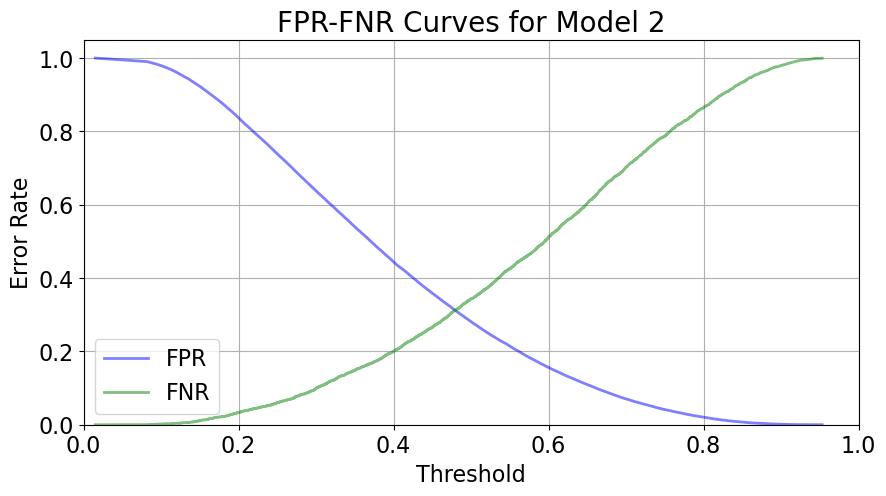

In [88]:

y_scores = model_2.predict_proba(validation_pool)[:, 1]

fpr, tpr, thresholds = roc_curve(validation_pool.get_label(), y_scores)

fnr = 1 - tpr

plt.figure(figsize=(10, 5))
style = {'alpha': 0.5, 'lw': 2}
plt.plot(thresholds, fpr, color='blue', label='FPR', **style)
plt.plot(thresholds, fnr, color='green', label='FNR', **style)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR Curves for Model 2', fontsize=20)
plt.legend(loc='lower left', fontsize=16)
plt.show()

In [89]:
probabilities = model_2.predict_proba(X_val)[:, 1]
threshold = 0.45
predictions = (probabilities >= threshold).astype(int)

In [90]:
class_report = classification_report(y_val, predictions)
print("\nModel 5 Classification Report at threshold 0.45:")
print(class_report)


Model 5 Classification Report at threshold 0.45:
              precision    recall  f1-score   support

           0       0.96      0.64      0.77     50882
           1       0.15      0.73      0.25      4469

    accuracy                           0.65     55351
   macro avg       0.56      0.69      0.51     55351
weighted avg       0.90      0.65      0.73     55351



In [91]:
probabilities = model_2.predict_proba(X_val)[:, 1]
threshold = 0.4
predictions = (probabilities >= threshold).astype(int)

In [92]:
class_report = classification_report(y_val, predictions)
print("\nModel 5 Classification Report at threshold 0.45:")
print(class_report)


Model 5 Classification Report at threshold 0.45:
              precision    recall  f1-score   support

           0       0.97      0.56      0.71     50882
           1       0.14      0.80      0.23      4469

    accuracy                           0.58     55351
   macro avg       0.55      0.68      0.47     55351
weighted avg       0.90      0.58      0.67     55351



---
- We can see changes in the outputs based on changes of the threshold for decision. 
- Reducing it to 0.45 helps as well, depending on the opportunity cost, or revenue lost due to classifying non defaulting person as defaulting, and costs of defaulting, this threshold can be changed. 
---

### SMOTE Features Filtering from XGBoost model and from Catboost model

#### Catboost SHAP analysis

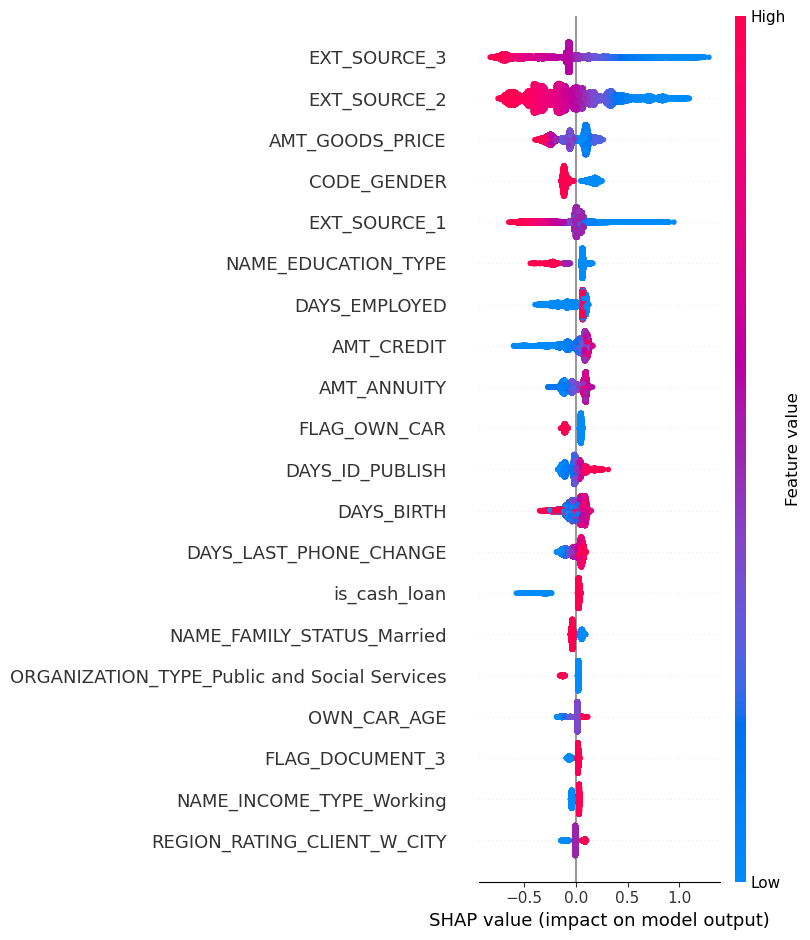

In [93]:
explainer_cat = shap.TreeExplainer(model_2)
shap_values_cat = explainer_cat.shap_values(X_val)
shap.summary_plot(shap_values_cat, X_val)

---
- Top features being EXT_SOURCE 3 and 2, followed by AMT_GOODS_PRICE
- We can see quite a lot of features related to demogprahics, like gender, profession, age, or simple ownership of a car etc. 
- This making the startup situation a bit better, as the models I've built at least dont need som very complex financial metrics to classify who will default and who will not. 
- It seems that combinations of relatively basic demographic characteristics and simple indicators of financial stability are sufficient. 
- This could allow the startup to offer maybe lower complexity product to wider range of banks, with data like this available to them. 
- For more specialized clients more specific models and features might get selected. 

---

In [94]:
mean_abs_shap_values_cat = np.abs(shap_values_cat).mean(axis=0)
shap_summary_df_cat = pd.DataFrame(
    {'Feature': X_val.columns, 'MeanAbsShapValue': mean_abs_shap_values_cat})
significant_features_cat = shap_summary_df_cat[shap_summary_df_cat['MeanAbsShapValue'] > 0]

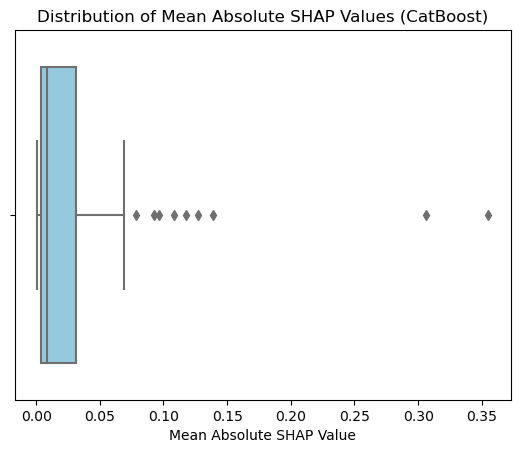

In [95]:
sns.boxplot(x=significant_features_cat['MeanAbsShapValue'], color="skyblue")
plt.title('Distribution of Mean Absolute SHAP Values (CatBoost)')
plt.xlabel('Mean Absolute SHAP Value')
plt.show()

- We see that large amount of features are bellow 0.05 value, pointing to feature redundancy.
- We might want to filter out these features for simpler models with equal predictive power. 
- We see higly predictive features are outliers in this context. We might want to focus only on them. 

In [96]:
significant_features_cat['MeanAbsShapValue'].describe()

count   75.00
mean     0.03
std      0.06
min      0.00
25%      0.00
50%      0.01
75%      0.03
max      0.36
Name: MeanAbsShapValue, dtype: float64

- I will choose the 0.03 threshold for SHAP values, as it is upper limit of IQR and will capture mostly higly useful outlier features.

##### SHAP Filtering

In [97]:
mean_abs_shap_values_cat = np.abs(shap_values_cat).mean(axis=0)
shap_summary_df_cat = pd.DataFrame(
    {'Feature': X_val.columns, 'MeanAbsShapValue': mean_abs_shap_values_cat})
significant_features_cat = shap_summary_df_cat[shap_summary_df_cat['MeanAbsShapValue'] > 0.03]['Feature'].tolist(
)
filtered_data_cat = filtered_data_final[significant_features_cat + ['TARGET']]

In [98]:
X_cat = filtered_data_cat.drop('TARGET', axis=1)
y_cat = filtered_data_cat['TARGET']
X_train_cat, X_temp_cat, y_train_cat, y_temp_cat = train_test_split(
    X_cat, y_cat, test_size=0.3, random_state=22, stratify=y_cat)
X_val_cat, X_test_cat, y_val_cat, y_test_cat = train_test_split(
    X_temp_cat, y_temp_cat, test_size=0.4, random_state=22, stratify=y_temp_cat)

train_pool_cat = Pool(X_train_cat, y_train_cat)
validation_pool_cat = Pool(X_val_cat, y_val_cat)

model_2.fit(train_pool_cat, eval_set=validation_pool_cat, plot=True)

y_pred_cat = model_2.predict(X_test_cat)
print("Classification Report for CatBoost with Filtered Features:")
print(classification_report(y_test_cat, y_pred_cat))
print("Confusion Matrix:")
print(confusion_matrix(y_test_cat, y_pred_cat))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6725081	best: 0.6725081 (0)	total: 24.7ms	remaining: 37s
100:	test: 0.7328180	best: 0.7328961 (27)	total: 2.57s	remaining: 35.5s
200:	test: 0.7363371	best: 0.7363371 (200)	total: 5.38s	remaining: 34.7s
300:	test: 0.7378524	best: 0.7378584 (299)	total: 7.99s	remaining: 31.8s
400:	test: 0.7390266	best: 0.7390266 (400)	total: 10.6s	remaining: 29s
500:	test: 0.7399743	best: 0.7399743 (500)	total: 13s	remaining: 25.9s
600:	test: 0.7408894	best: 0.7408894 (600)	total: 15.5s	remaining: 23.2s
700:	test: 0.7417092	best: 0.7417092 (700)	total: 18.2s	remaining: 20.8s
800:	test: 0.7425288	best: 0.7425288 (800)	total: 20.6s	remaining: 18s
900:	test: 0.7431172	best: 0.7431272 (897)	total: 23.1s	remaining: 15.3s
1000:	test: 0.7439601	best: 0.7439626 (999)	total: 25.5s	remaining: 12.7s
1100:	test: 0.7457739	best: 0.7457739 (1100)	total: 28.2s	remaining: 10.2s
1200:	test: 0.7482263	best: 0.7482263 (1200)	total: 31s	remaining: 7.73s
1300:	test: 0.7498413	best: 0.7498413 (1300)	total: 33.9s	re

- We can see comparable results of this filtered shap model.
- Almost no changes in comparison to original model. 

In [99]:
len(significant_features_cat)

19

- 19 features from 75 only, giving us same results. 

#### XGBoost SHAP analysis

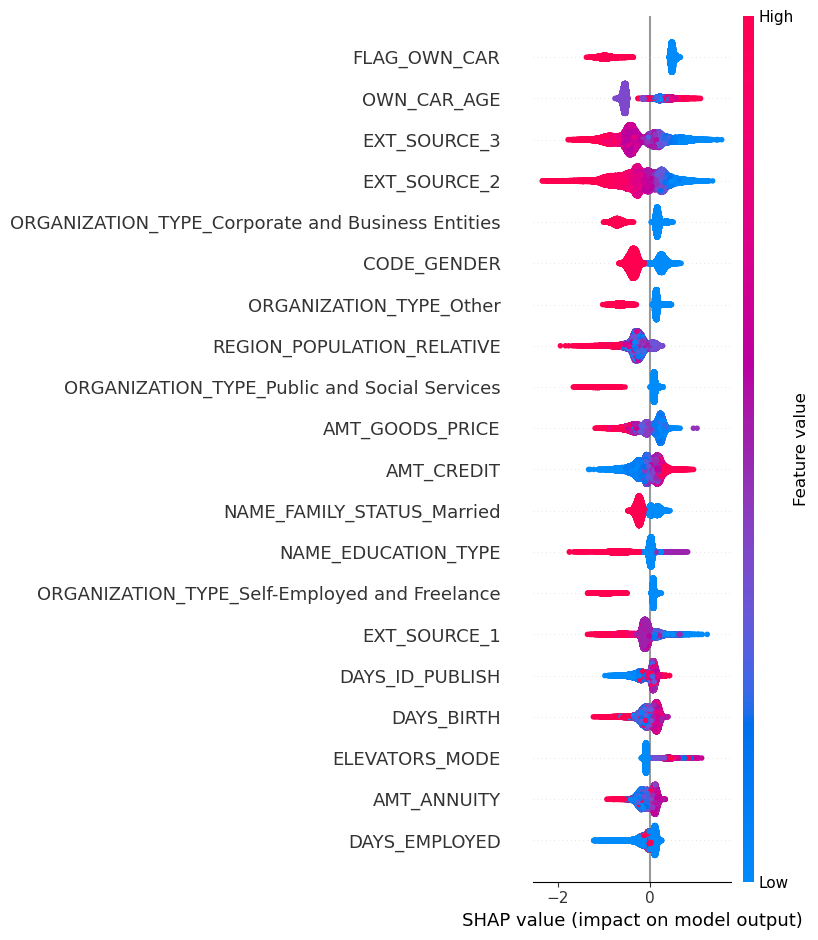

In [100]:
explainer_xgb = shap.TreeExplainer(model_xgb_cat_2)
shap_values_xgb = explainer_xgb.shap_values(X_val)
shap.summary_plot(shap_values_xgb, X_val)

---
- In here we see somewhat differen feature ranking than in catboost. 
- Still EXT features being high up. 
- And also features relating to cars being the most descriptive ones. 
- We also see wider range for impact on the model of features in XGBoost in comparison to catboost.
---

In [101]:
mean_abs_shap_values_xgb = np.abs(shap_values_xgb).mean(axis=0)
shap_summary_df_xgb = pd.DataFrame(
    {'Feature': X_val.columns, 'MeanAbsShapValue': mean_abs_shap_values_xgb})
significant_features_xgb = shap_summary_df_xgb[shap_summary_df_xgb['MeanAbsShapValue'] > 0]

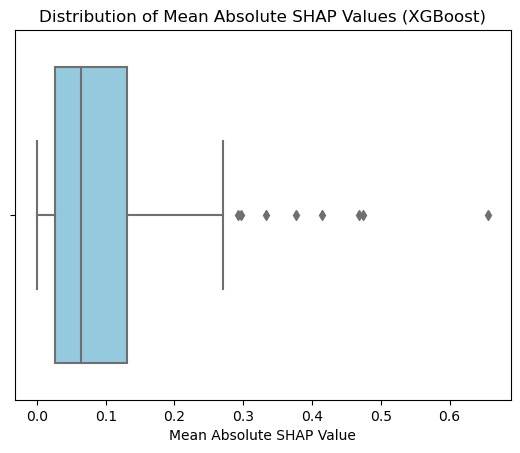

In [102]:
sns.boxplot(x=significant_features_xgb['MeanAbsShapValue'], color="skyblue")
plt.title('Distribution of Mean Absolute SHAP Values (XGBoost)')
plt.xlabel('Mean Absolute SHAP Value')
plt.show()

In [103]:
significant_features_xgb['MeanAbsShapValue'].describe()

count   75.00
mean     0.11
std      0.13
min      0.00
25%      0.03
50%      0.06
75%      0.13
max      0.66
Name: MeanAbsShapValue, dtype: float64

----
- We see overall higher feature SHAP values in XGboost model. 
- This might indicate XGBoost is utilizing features better than Catboost. This Claim would have to be explained further. 
- Cutoff point here might be somewhere arround 0.15 for higly predictive features. 

---

In [104]:
mean_abs_shap_values_xgb = np.abs(shap_values_xgb).mean(axis=0)
shap_summary_df_xgb = pd.DataFrame(
    {'Feature': X_val.columns, 'MeanAbsShapValue': mean_abs_shap_values_xgb})
threshold_xgb = 0.1
significant_features_xgb = shap_summary_df_xgb[
    shap_summary_df_xgb['MeanAbsShapValue'] > threshold_xgb
]['Feature'].tolist()

X_train_smote_filtered = X_train_smote[significant_features_xgb]
X_val_filtered = X_val[significant_features_xgb]
X_test_filtered = X_test[significant_features_xgb]

model_xgb_filtered = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=6,
    objective='binary:logistic',
    verbosity=1,
    reg_lambda=15,
    eval_metric="auc",
    scale_pos_weight=7
)

model_xgb_filtered.fit(
    X_train_smote_filtered,
    y_train_smote,
    early_stopping_rounds=100,
    eval_set=[(X_val_filtered, y_val)],
    verbose=100
)

y_val_pred_xgb_filtered = model_xgb_filtered.predict(X_val_filtered)
print("Validation Set Classification Report for XGBoost with Filtered Features:")
print(classification_report(y_val, y_val_pred_xgb_filtered))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_xgb_filtered))

[0]	validation_0-auc:0.64720
[100]	validation_0-auc:0.68848
[200]	validation_0-auc:0.70543
[300]	validation_0-auc:0.71693
[400]	validation_0-auc:0.72535
[500]	validation_0-auc:0.73323
[600]	validation_0-auc:0.74019
[700]	validation_0-auc:0.74604
[800]	validation_0-auc:0.75166
[900]	validation_0-auc:0.75701
[1000]	validation_0-auc:0.76211
[1100]	validation_0-auc:0.76691
[1200]	validation_0-auc:0.77124
[1300]	validation_0-auc:0.77528
[1400]	validation_0-auc:0.77902
[1499]	validation_0-auc:0.78297
Validation Set Classification Report for XGBoost with Filtered Features:
              precision    recall  f1-score   support

           0       0.96      0.78      0.86     50882
           1       0.20      0.62      0.30      4469

    accuracy                           0.76     55351
   macro avg       0.58      0.70      0.58     55351
weighted avg       0.90      0.76      0.81     55351

Confusion Matrix:
[[39514 11368]
 [ 1688  2781]]


In [105]:
len(significant_features_xgb)

26

- We see slightly different results for XGBoost with SHAP filtering. Pointing to more complex relationships between features in Xgboost maybe. 

#### SHAP Comparison 

In [106]:
mean_abs_shap_values_cat = np.abs(shap_values_cat).mean(axis=0)
shap_df_cat = pd.DataFrame(
    {'Feature': X_val.columns, 'CatBoost_SHAP': mean_abs_shap_values_cat})

mean_abs_shap_values_xgb = np.abs(shap_values_xgb).mean(axis=0)
shap_df_xgb = pd.DataFrame(
    {'Feature': X_val.columns, 'XGBoost_SHAP': mean_abs_shap_values_xgb})

shap_comparison_df = pd.merge(shap_df_cat, shap_df_xgb, on='Feature')

In [107]:
shap_comparison_df.describe()

,CatBoost_SHAP,XGBoost_SHAP
count,75.00,75.00
mean,0.03,0.11
std,0.06,0.13
min,0.00,0.00
25%,0.00,0.03
50%,0.01,0.06
75%,0.03,0.13
max,0.36,0.66


---
- Mean: On average, the SHAP values for XGBoost are higher than those for CatBoost (0.11 vs. 0.03). This suggests that, overall, features tend to have a greater impact on the output of the XGBoost model than on the CatBoost model.

- The standard deviation is higher for XGBoost (0.13) than for CatBoost (0.06), indicating that there's more variation in the impact that individual features have in the XGBoost model.

---

In [108]:
shap_comparison_df.head()

,Feature,CatBoost_SHAP,XGBoost_SHAP
0,LANDAREA_AVG,0.01,0.02
1,NONLIVINGAREA_AVG,0.00,0.05
2,ENTRANCES_AVG,0.01,0.06
3,ORGANIZATION_TYPE_Other,0.01,0.30
4,AMT_GOODS_PRICE,0.14,0.24


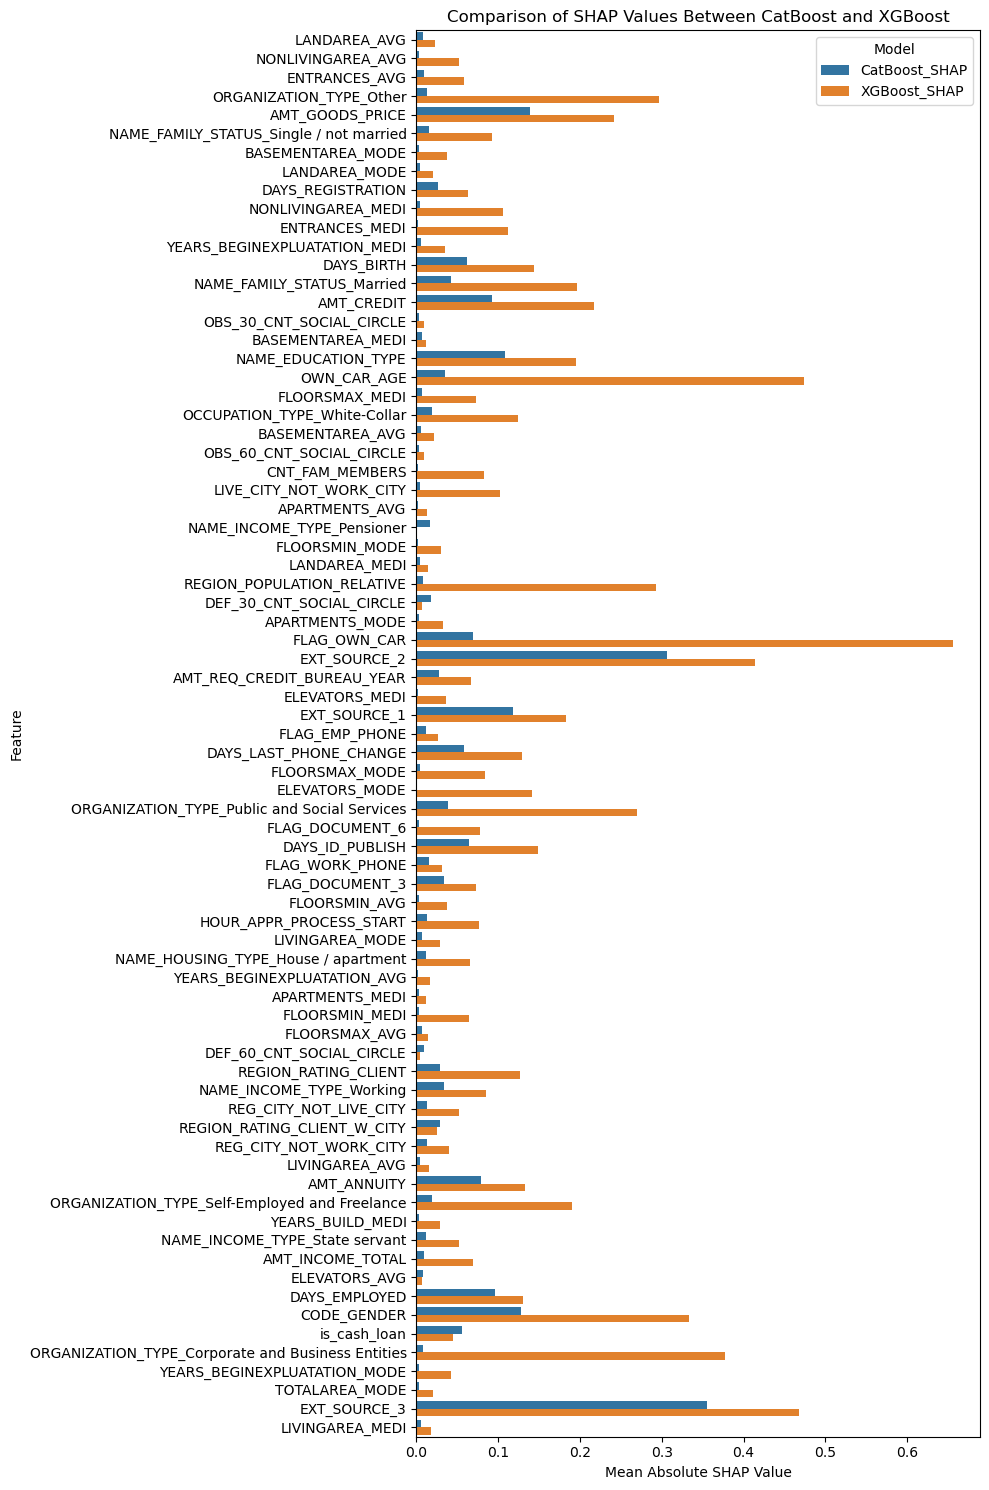

In [109]:
shap_comparison_melted = shap_comparison_df.melt(
    id_vars='Feature', var_name='Model', value_name='SHAP_Value')
plt.figure(figsize=(10, 15))
sns.barplot(x='SHAP_Value', y='Feature', hue='Model',
            data=shap_comparison_melted, ci=None)
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.title('Comparison of SHAP Values Between CatBoost and XGBoost')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

- We see quite big variability in SHAP values for these two models, for same features. Quite interesting to see. 

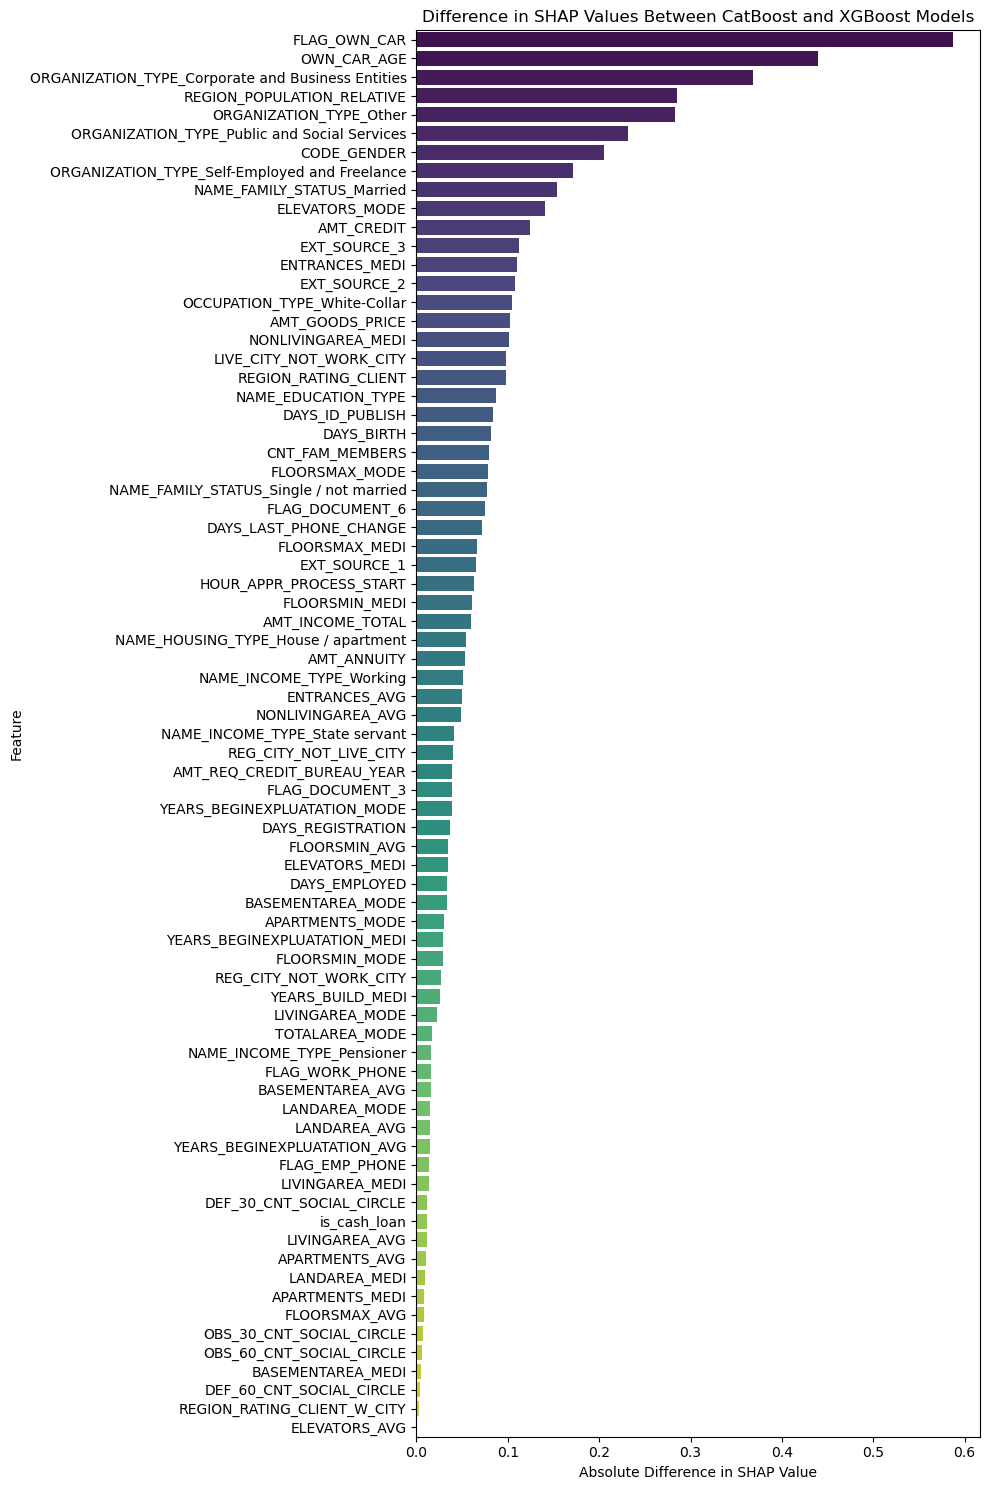

In [110]:
# Differences in SHAP values for each feature between the two models

shap_comparison_df['Difference'] = abs(
    shap_comparison_df['CatBoost_SHAP'] - shap_comparison_df['XGBoost_SHAP'])
shap_comparison_df_sorted = shap_comparison_df.sort_values(
    'Difference', ascending=False)
shap_comparison_df_sorted.reset_index(drop=True, inplace=True)
plt.figure(figsize=(10, 15))
sns.barplot(x='Difference', y='Feature',
            data=shap_comparison_df_sorted, palette='viridis')
plt.xlabel('Absolute Difference in SHAP Value')
plt.ylabel('Feature')
plt.title('Difference in SHAP Values Between CatBoost and XGBoost Models')
plt.tight_layout()
plt.show()

- Here we can see the diffrence between features and models. 

## Suggestions for Enhancements in Analysis and Models

1. **Comprehensive Statistical Testing**: Expand the scope of statistical analysis to include more robust tests, enabling a deeper understanding of the underlying data relationships and distributions.
    
2. **Iterative Modeling Approach**: Adopt a more iterative and experimental modeling strategy.
    
3. **Diverse Model Exploration**: While XGBoost and CatBoost have shown promising results, incorporating additional models (such as Random Forest, Neural Networks, or Ensemble methods) could provide valuable  insights and potentially uncover different aspects of the data.
    
4. **In-depth Feature Analysis**: Delve deeper into SHAP analysis to gain more nuanced insights into feature interactions and importance, leading to better-informed feature engineering and selection.
    
5. **Extensive Hyperparameter Tuning**: Employ a more exhaustive approach to hyperparameter tuning, possibly using advanced techniques.
    
6. **Advanced Feature Engineering**: Experiment with automated feature engineering tools like AutoFeat, which might uncover hidden relationships and enhance model accuracy.
    
7. **Precision in Handling Missing Values**: Investigate and implement more sophisticated methods for dealing with missing data, such as imputation techniques tailored to the specific characteristics of each feature.
    
8. **Experimenting with Categorical Data**: Test how CatBoost handles categorical features without explicit label encoding, leveraging its ability to naturally process categorical data.
    
9. **Increased Use of Visualizations**: Incorporate more visual aids to enhance data storytelling and provide clearer insights into the analysis process and results.
    
10. **Leverage Additional Datasets**: Investigate and integrate more data, especially from datasets related to the most significant features identified. This could be a second phase of the project, focusing on enriching the analysis with more diverse data sources.

11. **Unified Dataset Modeling**: Consider the challenge of combining all available datasets into one comprehensive dataset for analysis. This approach can provide a more holistic view, although it may introduce complexities in data preprocessing and feature alignment.
    
12. **Temporal Analysis**: If the datasets include time-based data, conducting a temporal analysis could uncover trends and patterns over time, which might be crucial for predicting defaults.
    

13. **Validation on External Datasets**: To test the generalizability of the models, consider validating them on external datasets that are similar in nature but not part of the original training set.
    
14. **Cost-Sensitive Learning**: Implement cost-sensitive learning approaches, especially if the financial cost of different types of misclassifications (false positives vs. false negatives) varies significantly.
    
15. **Post-Modeling Analysis**: After model development, perform a thorough post-modeling analysis, including error analysis and scenario testing, to understand where and why the model might fail.